# Lie Detection: Reliability of Relevant Predictors in Classifiers

The project aims at examining the reliability of predictors in classifiers used in the field of behavioral science. More specifically, the project’s goal is to determine the effectiveness and the replicability of various predictors in accurately identifying "faking" in psychological questionnaires. Realizing this goal could benefit the use of machine learning classifiers in various fields such as psychology.

### Tasks:
- Define metric too measure feauture contribution (Shap Values)
- Generate baseline results (no preprocessing)
- Perform agnostic feature selection methods
    - PCA
    - Sparse-PCA
    - Autoencoder
- Perform Intrinsic feature selection methods (Lasso Penalty)

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Phillippe Robert, 2041505, philippe.robert@studenti.unipd.it
- Mohammad Huzaifa Fazal, 2041507, mohammadhuzaifafazal.xxx@studenti.unipd.it

OUTLINE:
    
1. Introduction
   (including objective)
2. Dataset
3. EDA/Descriptive Analysis of data
4. Models used
    - Performance: F1 score
5. Conclusion

## Introduction

A psychological questionnaire is a tool used by researchers and practitioners in the field of psychology to gather information about an individual's thoughts, feelings, and behaviors. These questionnaires are typically self-report measures, meaning that the individual being assessed completes the questionnaire themselves. They can be used to assess a wide range of psychological constructs, such as personality, mood, and cognitive functioning. Questionnaires can be administered in a variety of ways, including online, in person, or via mail. The results of a psychological questionnaire can provide valuable insights into an individual's psychological functioning, helping researchers and practitioners to better understand and treat mental health conditions.

One important aspect to consider when administering psychological questionnaires is the potential for participants to provide false or misleading information. This is commonly referred to as "faking" on the questionnaire. Lying on a psychological questionnaire can occur for a variety of reasons, including the desire to appear more socially desirable, to avoid revealing sensitive information, or to influence the results in a certain way. These can be categorised into 'faking good' and 'faking bad'. The former is when someone tries to potray themselves in a good light, hiding or minimizing undesirable characteristics while the latter occurs when someone exaggerates a condition or symptom to gain advantage.

It is important to note that lying on a psychological questionnaire can impact the validity of the results, making it difficult to accurately assess an individual's psychological functioning and thus it is important to identify instances of "faking" in psychological questionnaires. Thus, this project aims to examine and detremine the reliability, effectiveness and replicability of predictors in various classifiers in detecting malingering on psychological questionnaires.

To accomplish this, we will conduct the following test.  N.B. We decided to use the F1-score metric instead of the accuracy due to imbalance in the datasets. 

* We will examine if different Machine Learning models with comparable F1-scores exhibit variations in their most important features selected, and this for all datasets. 

* We will analyze 20% of the items to determine the F1-score and its deviation from the original test. Furthermore, we will examine the concordance among classifiers in identifying the 20% best items.

* Do model-agnostic feature selection methods surpass model-dependent ones

* Investigate whether items selection inspired by psychometric methods outperforms model-based item selection.



## Dependencies: Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn import svm
import shap
# figure size in inches
plt.rcParams['figure.figsize'] = 11.7,8.27


#Import library needed to perferm the autoencoder features extration.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import tensorflow as tf

# Datasets

There are 13 datasets with each conatining psychological questionnaires of varying number of items (questions) to test specific aspects of mental health or well-being. 

Respondents in each questionnaire were asked to complete the questionnaire twice: Once, HONESTLY and a second time, FAKING the responses. Faking or lying can occur in two ways:
* Faking Good: where respondents portray themselves in a positive light. For example: hiding or minimizing undesired characteristics 
* Faking Bad: where respondents potray themselves in a negative light. For example, exaggerating a symptom or a disorder.

Here's a brief overview of the datasets

| No. | Dataset | Object |
| :- | :- | :- |
| 1 | ShortDT | Dark Triad |
| 2 | PMRQ | Memory Impairment |
| 3 | PCL | Post Traumatic Stress Disorder |
| 4 | NAQ_R | Mobbing |
| 5 | PHQ9_GAD7 | Anxious-Depressive Syndrome |
| 6 | PID5 | Personality |
| 7 | ShortPID5 |  Personality |
| 8 | PRFQ | Specific caregivers' ability to mentalize with their children |
| 9 | IESR | Post Traumatic Stress Disorder |
| 10 | R_NEO_PI | Big Five  |
| 11 | DDDT | Dark Triad |
| 12 | IADQ | Adjustment Disorder |
| 13 | BF | 5 Dimensions of human personality |


### Loading the 13 different datasets as DataFrame 

Here, we import the csv or excel file of the datasets. (Where NA values are present in the "Condition" column (specifying whether a response is an honest one or a faked one), we have dropped those rows)

In [3]:
BF_CTU_df = pd.read_csv("data/BF_df_CTU.csv", delimiter=",")
BF_OU_df = pd.read_csv("data/BF_df_OU.csv", delimiter=",")
BF_V_df = pd.read_csv("data/BF_df_V.csv", delimiter=",")
DT_CC_df = pd.read_csv("data/DT_df_CC.csv", delimiter=",")
DT_JI_df = pd.read_csv("data/DT_df_JI.csv", delimiter=";")
IADQ_df = pd.read_csv("data/IADQ_df.csv", delimiter=",")
IESR_df = pd.read_csv("data/IESR_df.csv", delimiter=",")
NAQR_df = pd.read_csv("data/NAQ_R_df.csv", delimiter=";")
PCL5_df = pd.read_csv("data/PCL5_df.csv", delimiter=";").dropna(subset=["CONDITION"])
PHQ9_df = pd.read_csv("data/PHQ9_GAD7_df.csv", delimiter=";")
PID5_df = pd.read_csv("data/PID5_df.csv", delimiter=";").dropna(subset=["CONDITION"])
PRFQ_df = pd.read_csv("data/PRFQ_df.csv", delimiter=",")
PRMQ_df = pd.read_csv("data/PRMQ_df.csv", delimiter=",")
DDDT_df = pd.read_csv("data/RAW_DDDT.CSV", delimiter=",")
SPID5_df = pd.read_csv("data/sPID-5_df.csv", delimiter=",")

RNEOPI_honest_df = pd.read_excel("data/Honest.xlsx", header=1)
RNEOPI_fake_df = pd.read_excel("data/Faked.xlsx", header=1)
RNEOPI_honest_df["CONDITION"] = "H"
RNEOPI_fake_df["CONDITION"] = "D"
RNEOPI_df = pd.concat([RNEOPI_honest_df, RNEOPI_fake_df])

For the rest of the NA values, they have been filled with the token "-999"

In [4]:
BF_CTU_df = BF_CTU_df.fillna("-999")
BF_OU_df = BF_OU_df.fillna("-999")
BF_V_df = BF_V_df.fillna("-999")
DT_CC_df = DT_CC_df.fillna("-999")
DT_JI_df = DT_JI_df.fillna("-999")
IADQ_df = IADQ_df.fillna("-999")
IESR_df = IESR_df.fillna("-999")
NAQR_df = NAQR_df.fillna("-999")
PCL5_df = PCL5_df.fillna("-999")
PHQ9_df = PHQ9_df.fillna("-999")
PID5_df = PID5_df.fillna("-999")
PRFQ_df = PRFQ_df.fillna("-999")
PRMQ_df = PRMQ_df.fillna("-999")
DDDT_df = DDDT_df.fillna("-999")
SPID5_df = SPID5_df.fillna("-999")
RNEOPI_df = RNEOPI_df.fillna("-999")

## Helper Functions

Here, we have defined some helper functions to breakdown the tasks into manageable bits and to perform repetitive tasks efficiently.

### 1. evaluate_clf:
A function to perform cross validation when training classifiers

    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (dict) {fit_time:[...], score_time:[...], estimator:[...], test_score:[...]}

In [5]:
def evaluate_clf(df, clf, cv):
    """
    Performs cross-validation of a classifier over a dataset
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (dict) {fit_time:[...], score_time:[...], estimator:[...], test_score:[...]}
    """
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1', return_estimator=True)
    
    return output

### 2. get_feature_importance:
This function calculates and returns the feature importance of each feature, relative to all the features. If the estimator is a Logistic Regression or SVC then the featuer importance is simply the ....

    Args:
        model_output: (list) sklearn fitted estimators
    
    Retruns:
        (dict) {predictor: value}

In [6]:
def get_feature_importance(model_output):
    """
    Averages feature importances / coefficient values from all the fitted estimators
    
    Args:
        model_output: (list) sklearn fitted estimators
    
    Retruns: (dict) {predictor: value}
    """
    
    n_folds = len(output["estimator"])
    coeficients = 0
    
    for estimator in output["estimator"]:
        if isinstance(estimator, LogisticRegression) or isinstance(estimator, svm.SVC):
            coeficients += estimator.coef_[0] # TODO: RF uses feature_importances insted of coef_
        else:
            coeficients += estimator.feature_importances_
    coeficients = np.abs(coeficients/n_folds)
    res = dict(zip(estimator.feature_names_in_, coeficients))

    return res

### 3. plot_feature_importance: 
A function to help plot bar charts for the feature importances of the predictors. The x-axis will be labelled as "Feature Name" and the y-axis will be labelled as "Abs(Importance Score)"

    Args:
        feature_importance: (dict) dictionary with key:feature name and value:importance
        title: (str) title of the chart

In [7]:
def plot_feature_importance(feature_importance, title):
    """
    Plots a bar chart of the importance/coefficients of the predictors
    
    Args:
        feature_importance: (dict) dictionary with key:feature name and value:importance
        title: (str) title of the chart
    """
    
    plt.bar(x=feature_importance.keys(), height=feature_importance.values())
    plt.title(title)
    plt.xlabel("Feature Name")
    plt.ylabel("Abs(Importance Score)")
    plt.show()

### 4. get_shap_values: 
This function computes the shap-values for each fold of a cross-validation of a classifier. Shap-values and their significance is explained in the next section.

    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (tuple) shap_values: (shap.Explainer), f1_score: float

In [8]:
def get_shap_values(clf, df, cv):
    """
    Performs cross-validation of a classifier over a dataset
    and computes the shap-values for each fold.
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (tuple) shap_values: (shap.Explainer), f1_score: float
    """
    
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    list_shap_values = list()
    f1_scores = list()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #training model
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        f1_scores.append(f1_score(y_test, preds))

        #explaining model
        explainer = shap.Explainer(clf, X_train)
        if isinstance(clf, RandomForestClassifier):
            shap_values = explainer(X_test, check_additivity=False)
        else:
            shap_values = explainer(X_test)

        #for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        
    # combining results from all iterations
    shap_values = np.array(list_shap_values[0].values)
    for i in range(1, cv):
        shap_values = np.concatenate((shap_values, np.array(list_shap_values[i].values)), axis=0)
    shap_values = shap.Explanation(shap_values, feature_names=X_train.columns)
    
    return shap_values, np.mean(f1_scores)

## Baseline Feature Importance - Shap Values

### Why Shap Values?

Measuring feature contribution in a classification task is important because it helps to understand how each feature contributes to the final prediction made by the model. Thus, computing it property can provide valuable insights into the inner workings of the classification model, which is useful for the interpretability of the tasks. 

However, different models have different ways of assigning scores to their input features based on how useful they are in predicting the target value. For example, random forest is an ensemble model composed of many decision tress that use the information gain or the Gini impurity to measure features importance, while logistic regression use the sigmoid function to assign weights to the inputs to indicate their importance. From this point of view, it is the equivalent of comparing *apples* to *oranges*.  

The plot below appears to indicate that the various models assign importance to completely different features in order to generate their predictions in the dataset BF_CTU_df. But, can we be certain of this degree of divergence ?

<AxesSubplot:xlabel='variable', ylabel='value'>

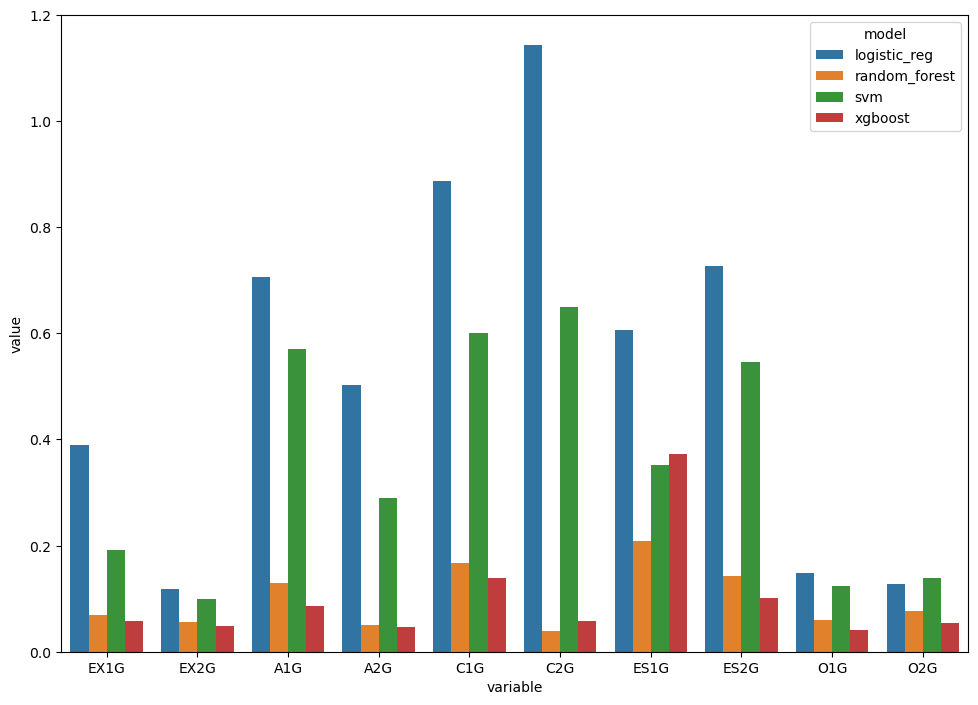

In [19]:
clf = LogisticRegression(solver="lbfgs", penalty=None)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_lr = get_feature_importance(output)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_rf = get_feature_importance(output)

clf = svm.SVC(kernel="linear")
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_svm = get_feature_importance(output)

clf = XGBClassifier(random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_xgboost = get_feature_importance(output)

feature_importance_lr['model'] ="logistic_reg"
feature_importance_rf['model'] ="random_forest"
feature_importance_svm['model'] ="svm"
feature_importance_xgboost['model'] ="xgboost"

comparison_df = pd.DataFrame.from_dict([feature_importance_lr, 
                        feature_importance_rf, 
                        feature_importance_svm,
                        feature_importance_xgboost])

comparison_df = comparison_df.melt(id_vars=["model"])

sns.barplot(data=comparison_df, x="variable", y="value", hue="model")

Here, comes the introduction of our approach to adress this problem. The Shapley value, a explanable and model-agnostic method, is helpful in providing insight into the comparison of various models. It is a method to distribute the value of a cooperative game (?) among its participants in a fair manner. More specifically, Shapley value assigns a unique contribution score to each feature by evaluating the average marginal contribution of each feature across all possible coalitions. Because it considers the contribution of each feature in various scenarios, it is a fair and powerful method to assign importance to the features in a model. Therefore, it allows to compare models to each other in an even playing field.

Below, we compute the feature importances using Shapley value of the four models on the dataset BF_CTU_df.

## Models

In this section, we run various models/classifiers to examine and determine the reliability, effectiveness and replicability of predictors in detecting malingering on our datasets. The models/classifiers used are:
1.  Logistic Regression
2.  Random Forest
3.  SVM
4.  XGBoost

### 1. Logistic Regression

Logistic regression (LR) is a method of classification where a sigmoid function is used to predict a binary outcome. It uses a linear boundary to separate the data into different classes, and the output is a probability of the observation belonging to a specific class. Logistic regression is a good starting point in selecting various models because it is easy to understand and relatively efficient as it does not require large amounts of computational resources. Coefficients produced by a fitted logistic regression model are essentially the log expected change in log odds given the a unit increase.

Below, we can see the shap-values of the logistic regression model plotted as a barchart, along with the cross-validated F1 score of 0.8098, approximately. According to the Logistic Regression model, the top 5 most imporant features are C1G, ES2G, C2G, ES1G, and A1G, respectively.

Cross-Validated F1-Score: 0.8098047607227533


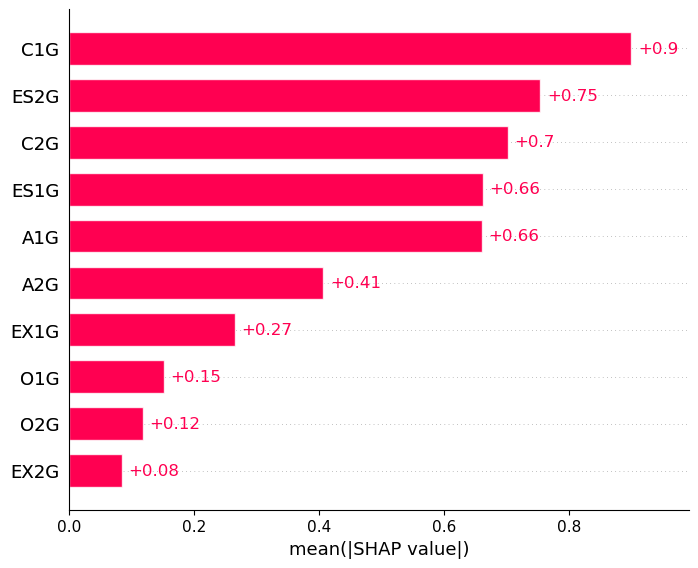

In [8]:
clf = LogisticRegression(solver="lbfgs", penalty=None)
shap_values_lr, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_lr)

### 2. Random Forest

Random Forest is a method that uses a combination of multiple decision trees to make predictions. Each tree is trained on a sample of observations and a subset of features, which leads to variation among the trees and reduces bias. The final prediction is determined by a majority vote among the trees. The use multiple decision trees helps to reduce overfitting as well, as the errors made by one tree can be compensated for by the other. Even though, using an ensemble method improves the robustness and accuracy of the prediction, it makes the model more computationally heavy and less interpretable.

Below, we can see the shap-values of the random forest model plotted, along with the cross-validated F1 score of 0.8264, approximately. According to this model, the top 5 most imporant features are ES1G, C1G, ES2G, A1G, and O2G, respectively. 

Even though the order of imporance for the top 5 most important features has shuffled between the logistic regression model and random forest model, 4 out of 5 the features are the same in both top-5 lists. Thus, so far both models relatively agree with each other as the absolute shap value difference between the features isnt very significant.

Cross-Validated F1-Score: 0.8264135923136632


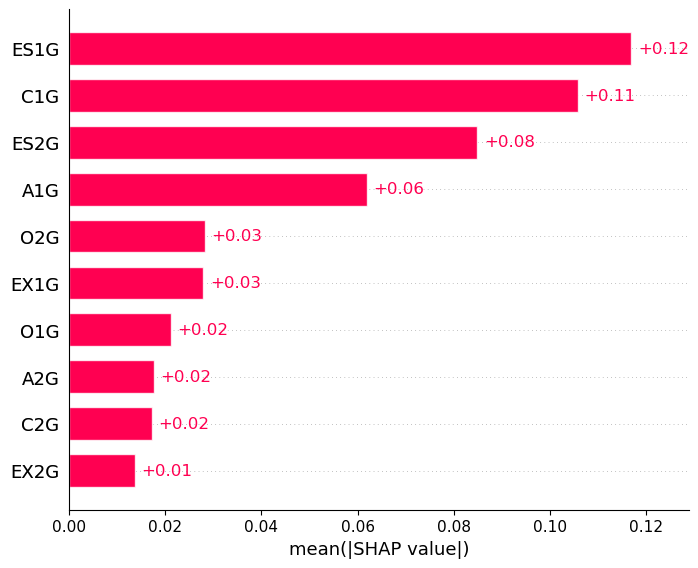

In [9]:
clf = RandomForestClassifier(random_state=42)
shap_values_rf, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_rf[:,:,1])

### 3. Support Vector Classification (SVC)

Support Vector Classification (SVC) is a supervised machine learning method that uses a subset of the data points called support vectors to find the best boundary (called the margin hyperplane) to separate the different classes. It is considered a linear classifier, but it can also be used to solve non-linear classification problems by applying the kernel trick, such as using the Radial Basis Function, polynomial, and sigmoid. This technique improves the efficiency and reduces the error caused by poor decision boundaries. However, here we have used the linear kernel (why?). SVC is considered robust as it is not affected by the presence of outliers in the datasets.

Below, we can see the shap-values of the SVC model plotted, along with the cross-validated F1 score of 0.8193, approximately. According to this model, the top 5 most imporant features are C1G, ES2G, A1G, ES1G and C2G, respectively.

Again, the top-5 most important features are relatively the same among the 3 models so far. In fact, the SVC model has the same top-5 features as the linear regression model, with a slight change in order.


LR: C1G, ES2G, C2G, ES1G, and A1G
RF: ES1G, C1G, ES2G, A1G, and O2G,
SVC: C1G, ES2G, A1G, ES1G and C2G

Cross-Validated F1-Score: 0.8193417996883913


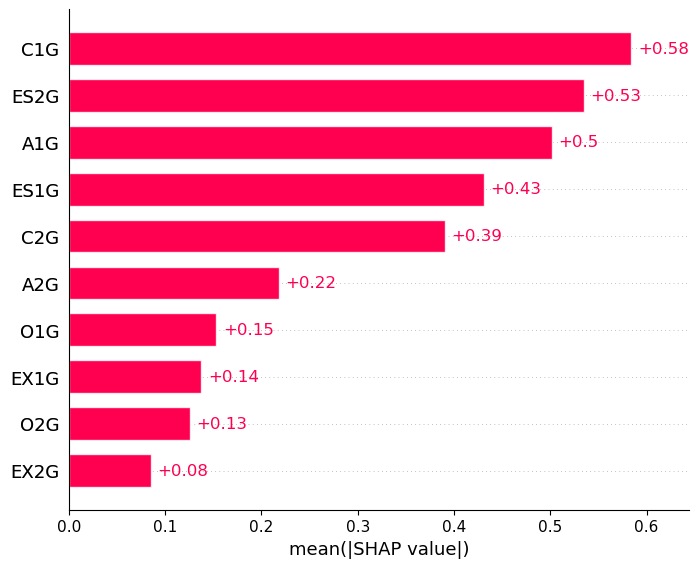

In [10]:
clf = svm.SVC(kernel="linear")
shap_values_svm, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_svm)

### 4. XGBoost

XGBoost is a type of gradient boosting algorithm that uses a combination of weak decision trees to make predictions. It is designed to be parallelizable and efficient, which makes it a powerful tool for large datasets. The algorithm works by iteratively building decision trees to correct the errors of the previous trees, with more emphasis on the errors made in the earlier trees. It also uses a learning rate, which acts as a form of regularization by shrinking the boosting process. Because decision trees are highly interpretable, XGBoost also allows for understanding the importance of each feature in the classification process.

Below, we can see the shap-values of the XGBoost model plotted, along with a cross-validated F1 score of 0.81156, approximately. According to this model, the top 5 most imporant features are C1G, ES2G, ES1G, A1G, and A2G, respectively.

All 4 models produce the approximately the same top-5 most important features. 

LR: C1G, ES2G, C2G, ES1G, and A1G
RF: ES1G, C1G, ES2G, A1G, and O2G,
SVC: C1G, ES2G, A1G, ES1G and C2G
XGBoost: C1G, ES2G, ES1G, A1G, and A2G

Cross-Validated F1-Score: 0.8115609110462632


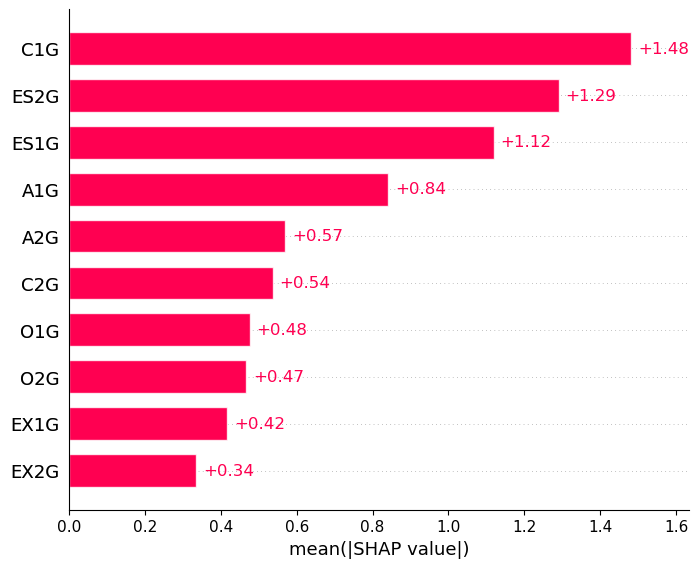

In [11]:
clf = XGBClassifier(random_state=42)
shap_values_xgboost, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_xgboost)

### Model Comparisons

Now it is time to compare the models together. To do so, for each feature we compute its relative importance by dividing the absolute value of the feature importances by the sum of all features importance absolute values. At this point, we have the relative impact of the specific feature in influencing the model to make its prediction, and thus we are finally able to evaluate the models together.

In [12]:
def compute_relative_shap_values(shap_values, col_names):    
    mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)
    relative_shap_values = mean_shap_values / np.sum(mean_shap_values)
    relative_shap_values = dict(zip(col_names, relative_shap_values))
    return relative_shap_values

In [13]:
def compare_clfs(df, 
                 df_name:None,
                 cv=5, 
                 lr_penalty=None, 
                 lr_C=1.0, 
                 svm_penalty=None,
                 svm_C=1.0, 
                 reg_alpha=0.0,
                 plot_comparison=True,
                 return_df=False,
                 return_performance_df=None,
                 plot_name=None,
                 path=None):
    
    if lr_penalty != None:
        solver = "liblinear"
    else:
        solver = "lbfgs"

    lr = LogisticRegression(solver=solver, penalty=lr_penalty, C=lr_C)
    shap_values_lr, f1_lr = get_shap_values(lr, df, cv)
    print(f"Cross-Validated F1-Score - Logistic Regression: {f1_lr}")
    
    rf = RandomForestClassifier(random_state=42)
    shap_values_rf, f1_rf = get_shap_values(rf, df, cv)
    print(f"Cross-Validated F1-Score - Random Forest: {f1_rf}")
    
    if svm_penalty == None:
        svm_c = svm.SVC(kernel="linear")
        shap_values_svm, f1_svm = get_shap_values(svm_c, df, cv)
        print(f"Cross-Validated F1-Score - SVM: {f1_svm}")
    else:
        svm_c = svm.LinearSVC(penalty=svm_penalty, C=svm_C, dual=False)
        shap_values_svm, f1_svm = get_shap_values(svm_c, df, cv)
        print(f"Cross-Validated F1-Score - SVM: {f1_svm}")
        
    xgboost = XGBClassifier(random_state=42, reg_alpha=reg_alpha)
    shap_values_xgboost, f1_xgboost = get_shap_values(xgboost, df, cv)
    print(f"Cross-Validated F1-Score - XGBoost: {f1_xgboost}")
    

    rel_shap_values_lr = compute_relative_shap_values(shap_values_lr, df.columns)
    rel_shap_values_rf = compute_relative_shap_values(shap_values_rf[:,:,1], df.columns)
    rel_shap_values_svm = compute_relative_shap_values(shap_values_svm, df.columns)
    rel_shap_values_xgboost = compute_relative_shap_values(shap_values_xgboost, df.columns)

    rel_shap_values_lr['model'] ="logistic_reg"
    rel_shap_values_rf['model'] ="random_forest"
    rel_shap_values_svm['model'] ="svm"
    rel_shap_values_xgboost['model'] ="xgboost"

    comparison_df = pd.DataFrame.from_dict([rel_shap_values_lr, 
                            rel_shap_values_rf, 
                            rel_shap_values_svm,
                            rel_shap_values_xgboost])

    comparison_df = comparison_df.melt(id_vars=["model"])

    if svm_penalty != None:
        comparison_df = comparison_df[comparison_df.model != "random_forest"]

    if plot_comparison:
        ax = sns.barplot(data=comparison_df, x="variable", y="value", hue="model")
        ax.set_title(f'Shap Value Comparison - Data Set: {df_name}')
        ax.set_ylabel('Relative Shap Value Contribution')
        ax.set_xlabel('Feature')
        plt.xticks(rotation=45)
        if plot_name:
            plt.savefig(f'{path}/{plot_name}.png', bbox_inches='tight')
        plt.show()
    
    if return_performance_df:
        performance_df = pd.DataFrame({"Dataset": [df_name, df_name, df_name, df_name],
                                       "Model": ["lr", "rf", "svm", "xgboost"],
                                       "F1": [np.round(f1_lr, 2), 
                                              np.round(f1_rf, 2), 
                                              np.round(f1_svm, 2), 
                                              np.round(f1_xgboost, 2)]})
        return performance_df
    
    if return_df:
        return comparison_df

Cross-Validated F1-Score - Logistic Regression: 0.8098047607227533
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8193417996883913
Cross-Validated F1-Score - XGBoost: 0.8115609110462632


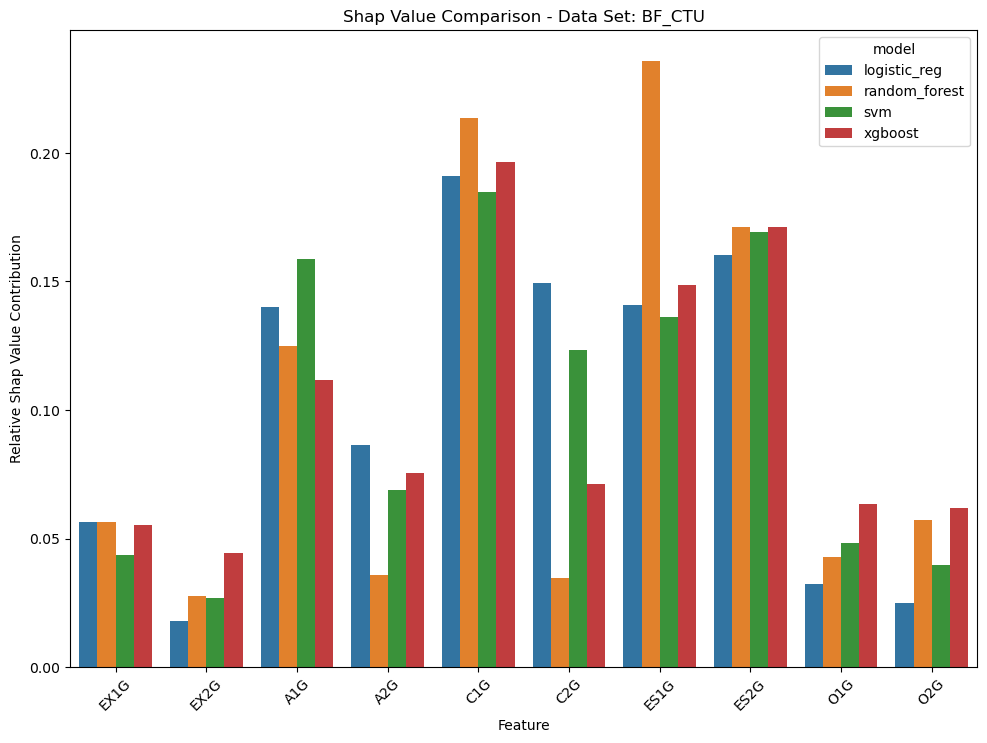

In [55]:
compare_clfs(BF_CTU_df, df_name="BF_CTU")

We can see that there is more similarity between the feature importances among the different models when compared to the previous method. Therefore, we will use Shapley value as the explanation method for the rest of our project. 

## Feature Selection Methods

In this section, we use 4 methods of feature selection to select a subset of the most relevant features of the datasets. The 4 methods are:
1. Principal Component Analysis (PCA)
2. Sparse Component Analysis (Sparse - PCA)
3. Autoencoder

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a linear method used to reduce the dimensionality of a dataset. It transforms the features in the dataset into a new feature space where the new features are uncorrelated and ordered by the amount of variance they explain in the data. These new features are called principal components, and by taking just the first few principal components, we are able to select the features that explain the most variance in the data and thus are the most important.

In [11]:
def perform_pca(df, ratio):
    n_components = int(np.round(ratio * (len(df.columns) - 1)))
    X = df.loc[:, df.columns != 'CONDITION']
    X_std = StandardScaler().fit_transform(X)    
    
    X_pca = pd.DataFrame(PCA(n_components=n_components, random_state=42).fit_transform(X_std))
    X_pca.columns = [f"c_{i}" for i in range(n_components)]
    X_pca = pd.concat([X_pca, df.CONDITION], axis = 1)
    return X_pca

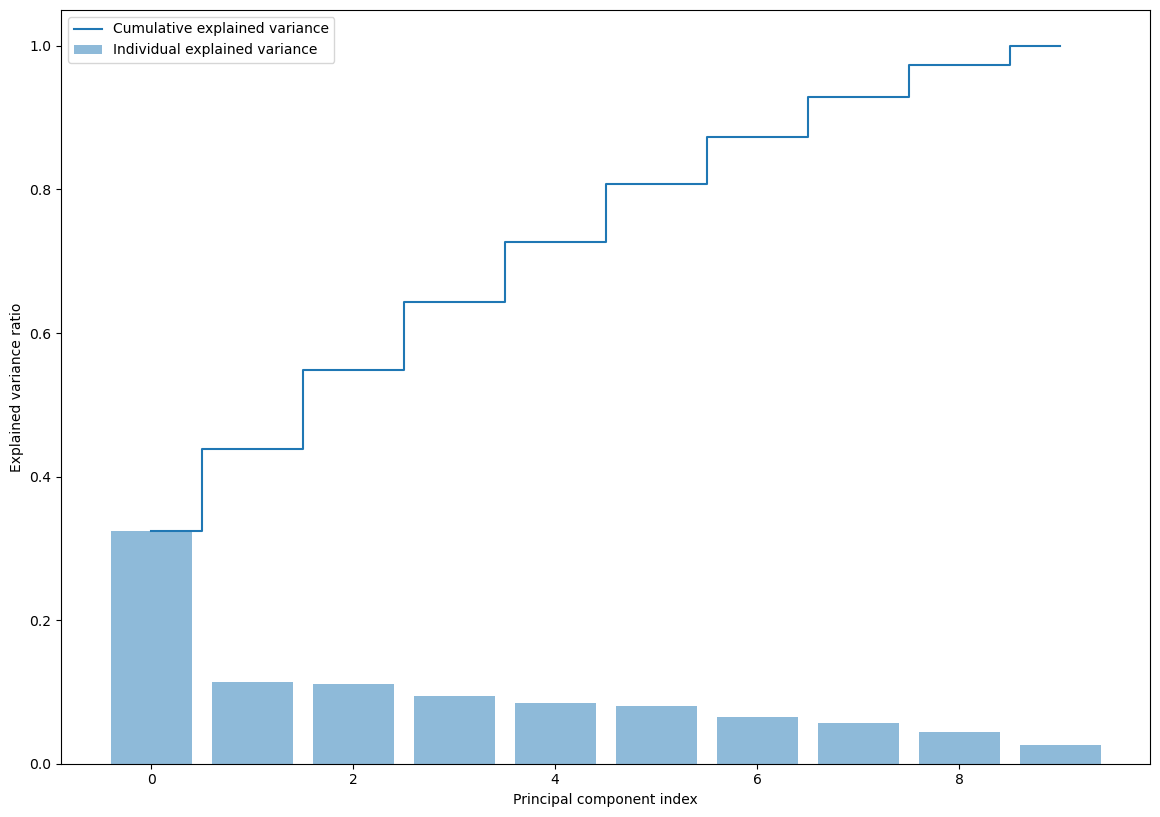

In [16]:
features = BF_CTU_df.columns.drop("CONDITION")
feature_values = BF_CTU_df.loc[:, features].values #separating the features
feature_values_std = StandardScaler().fit_transform(feature_values)

#Finding explained variance for PCA
pca = PCA()
feature_values_pca = pca.fit_transform(feature_values_std) #Determine transformed feature
exp_var_pca = pca.explained_variance_ratio_ #Determine explained variance using explained_variance_ration_ attribute

cum_sum_eigenvalues = np.cumsum(exp_var_pca) #Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#We can see that the first 6 components captures 80% of the total variance. Thus, I will try PCA with 6 components. 

From the PCA plot above, we can observe that  the first 6 principal components capture about 80% of the data, with the first one itself capturing about 30-35% of the data. 

(Possible to changethe index of the plot to start from 1 instead of 0)

Cross-Validated F1-Score - Logistic Regression: 0.8166888037619323
Cross-Validated F1-Score - Random Forest: 0.8248340779352914
Cross-Validated F1-Score - SVM: 0.8174075224762861
Cross-Validated F1-Score - XGBoost: 0.7986955660609631


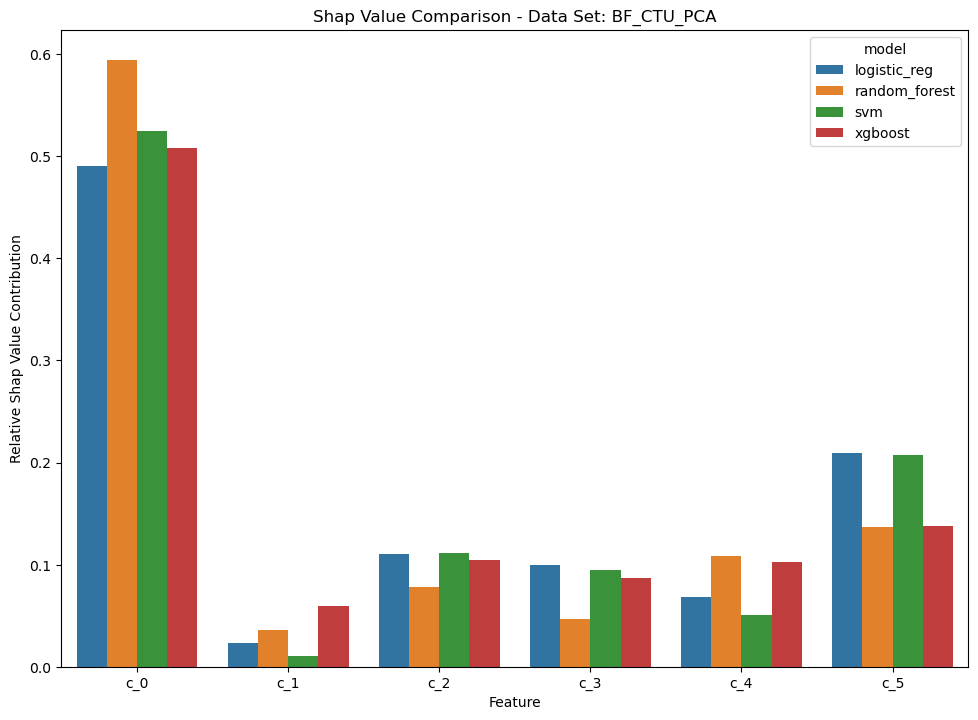

In [17]:
BF_CTU_df_pca = perform_pca(BF_CTU_df, 0.6)
compare_clfs(BF_CTU_df_pca, df_name="BF_CTU_PCA")

Here are the F1 scores after performing PCA.

| No. | Model | F1 Score |
| :- | :- | :- |
| 1 | Logistic Regression | 0.8167 |
| 2 | Random Forest | 0.8248 |
| 3 | SVM | 0.8174 |
| 4 | XGBoost | 0.7987 |


From the plot above, it can be observed that all models agree with each other in terms of the order of feature importance but slightly defer in quantifying the specific importance. For example, for feature c_0 random forest gives it a relative importance closer to 0.6 while the rest of the models give c_0 a relative importance closer to 0.5. A similar observation can be made in feature c_5.

### Sparce - Principal Component Analysis (Sparse-PCA)

Sparse-PCA is a variation of PCA that tries to find principal components that are sparse, meaing with a small number of non-zero elements. A sparse representaiton of the data is obtained in the form of linear combinations of the original features.

In [12]:
def perform_sparce_pca(df, ratio):
    n_components = int(np.round(ratio * (len(df.columns) - 1)))
    X = df.loc[:, df.columns != 'CONDITION']
    X_std = StandardScaler().fit_transform(X)    
    
    X_spca = pd.DataFrame(SparsePCA(n_components=n_components, random_state=42).fit_transform(X_std))
    X_spca.reset_index(inplace=True, drop=True)
    df.reset_index(inplace=True, drop=True)
    X_spca.columns = [f"c_{i}" for i in range(n_components)]
    X_spca = pd.concat([X_spca, df.CONDITION], axis = 1)
    return X_spca

In [30]:
BF_CTU_df_spca

,c_0,c_1,c_2,c_3,c_4,c_5,CONDITION
0,0.176342,0.327228,1.534813,0.304193,0.442449,0.354438,H
1,-0.514008,0.828019,-0.404491,0.656752,-0.108592,0.387022,H
2,-0.358161,0.840119,-0.300387,-0.602992,-0.014732,0.430978,H
3,1.274414,0.725576,-0.427190,-1.005719,-2.390651,0.396786,H
4,-0.120692,1.468759,-0.767799,0.319863,1.244307,0.250861,H
...,...,...,...,...,...,...,...
437,-0.077845,0.581133,-1.410370,0.872929,0.470666,-0.599373,D
438,1.129044,-1.229531,-0.431858,-0.701120,0.684549,0.409091,D
439,0.350032,0.444976,-0.485007,0.564153,1.441904,0.407892,D
440,0.840443,0.609681,-0.535091,0.595517,0.311706,0.349437,D


Cross-Validated F1-Score - Logistic Regression: 0.8144600439006368
Cross-Validated F1-Score - Random Forest: 0.829179133877936
Cross-Validated F1-Score - SVM: 0.8248975118662516
Cross-Validated F1-Score - XGBoost: 0.7988883090337802


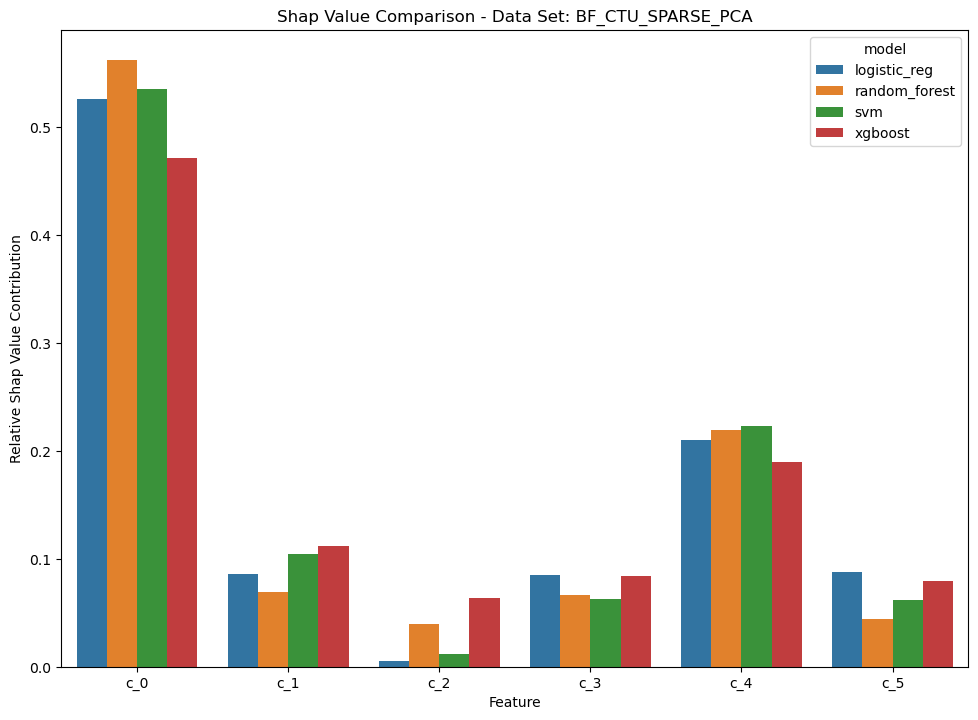

In [19]:
BF_CTU_df_spca = perform_sparce_pca(BF_CTU_df, 0.6)
compare_clfs(BF_CTU_df_spca, df_name="BF_CTU_SPARSE_PCA")

Here are the F1 scores after performing Sparse-PCA.

| No. | Model | F1 Score |
| :- | :- | :- |
| 1 | Logistic Regression | 0.0.8145 |
| 2 | Random Forest | 0.8292 |
| 3 | SVM | 0.8249 |
| 4 | XGBoost | 0.7989 |

Here, similar to PCA, sparse-PCA computes c_0 as the most important feature by a large margin than the rest and also has random forest giving a higher relative shap value than the other models to c_0. However, the second most important feature is c_4 instead of c_5 in PCA.

### Autoencoder

Autoencoders are a tupe of neural network architecture that is used for dimentionality reduction and thus can be used for feature selection as well. Autoencoders learn a compressed representation of the input data, called encodings, and use these encodings to reconstruct the original input data. Since the encodings a smaller representation of the data, and enough to reconstruct the original input, they naturally select the most important features and thus, can be used as a good feature selection method.

In [9]:
def run_autoencoder(df, ratio, epochs, df_name): 
    #ratio define pourcentage of features in bottleneck (latent space)
    X = df.loc[:, df.columns != 'CONDITION']
    y = df.loc[:, df.columns == 'CONDITION']
    
    #number of features at the start (input)
    n_inputs = X.shape[1]
    
    # spliting the data with StratifiedKFold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #scaling the data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)
    
    #Difining encoder
    visible = Input(shape=(n_inputs,))
    
    e = Dense(n_inputs*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    e = Dense(n_inputs)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    
    #Bottleneck
    n_bottleneck = round(float(n_inputs) * ratio)
    bottleneck = Dense(n_bottleneck)(e)
    
    #Difining decoder
    d = Dense(n_inputs)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Dense(n_inputs*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)
    
    output = Dense(n_inputs, activation='linear')(d)
    
    #defing the autoencoder model
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    #Ploting the model and the loss
    plot_model(model, 'autoencoder_compress.png', show_shapes=True)
    
    history = model.fit(X_train, X_train, epochs=epochs, batch_size=16, verbose=2, validation_data=(X_test,X_test))
    
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # define an encoder model (without the decoder)
    encoder = Model(inputs=visible, outputs=bottleneck)
    plot_model(encoder, 'encoder_compress.png', show_shapes=True)
    # save the encoder to file
    encoder.save(df_name + '_encoder.h5')
    
    return encoder

In [10]:
def perform_feature_extraction(df, ratio, epochs, df_name):
    n_components = int(np.round(ratio * (len(df.columns) - 1)))
    X = df.loc[:, df.columns != 'CONDITION']
    
    encoder = run_autoencoder(df, ratio, epochs, df_name)
    
    X_enc = pd.DataFrame(encoder.predict(X))
    X_enc.columns = [f"c_{i}" for i in range(n_components)]
    X_enc = pd.concat([X_enc, df.CONDITION], axis = 1)
    return X_enc

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
23/23 - 1s - loss: 0.8600 - val_loss: 0.4213 - 1s/epoch - 53ms/step
Epoch 2/200
23/23 - 0s - loss: 0.5183 - val_loss: 0.3742 - 78ms/epoch - 3ms/step
Epoch 3/200
23/23 - 0s - loss: 0.3523 - val_loss: 0.3159 - 83ms/epoch - 4ms/step
Epoch 4/200
23/23 - 0s - loss: 0.2428 - val_loss: 0.2615 - 85ms/epoch - 4ms/step
Epoch 5/200
23/23 - 0s - loss: 0.1725 - val_loss: 0.2147 - 87ms/epoch - 4ms/step
Epoch 6/200
23/23 - 0s - loss: 0.1261 - val_loss: 0.1732 - 104ms/epoch - 5ms/step
Epoch 7/200
23/23 - 0s - loss: 0.1021 - val_loss: 0.1462 - 84ms/epoch - 4ms/step
Epoch 8/200
23/23 - 0s - loss: 0.0838 - val_loss: 0.1239 - 90ms/epoch - 4ms/step
Epoch 9/200
23/23 - 0s - loss: 0.0789 - val_loss: 0.1004 - 92ms/epoch - 4ms/step
Epoch 10/200
23/23 - 0s - loss: 0.0677 - val_loss: 0.0902 - 77ms/epoch - 3ms/step
Epoch 11/200
23/23 - 0s - l

Epoch 99/200
23/23 - 0s - loss: 0.0365 - val_loss: 0.0289 - 78ms/epoch - 3ms/step
Epoch 100/200
23/23 - 0s - loss: 0.0344 - val_loss: 0.0285 - 124ms/epoch - 5ms/step
Epoch 101/200
23/23 - 0s - loss: 0.0353 - val_loss: 0.0283 - 77ms/epoch - 3ms/step
Epoch 102/200
23/23 - 0s - loss: 0.0347 - val_loss: 0.0289 - 81ms/epoch - 4ms/step
Epoch 103/200
23/23 - 0s - loss: 0.0363 - val_loss: 0.0291 - 79ms/epoch - 3ms/step
Epoch 104/200
23/23 - 0s - loss: 0.0367 - val_loss: 0.0290 - 68ms/epoch - 3ms/step
Epoch 105/200
23/23 - 0s - loss: 0.0378 - val_loss: 0.0290 - 80ms/epoch - 3ms/step
Epoch 106/200
23/23 - 0s - loss: 0.0354 - val_loss: 0.0292 - 70ms/epoch - 3ms/step
Epoch 107/200
23/23 - 0s - loss: 0.0349 - val_loss: 0.0290 - 66ms/epoch - 3ms/step
Epoch 108/200
23/23 - 0s - loss: 0.0349 - val_loss: 0.0288 - 66ms/epoch - 3ms/step
Epoch 109/200
23/23 - 0s - loss: 0.0353 - val_loss: 0.0284 - 71ms/epoch - 3ms/step
Epoch 110/200
23/23 - 0s - loss: 0.0348 - val_loss: 0.0287 - 71ms/epoch - 3ms/step
Epoc

Epoch 198/200
23/23 - 0s - loss: 0.0310 - val_loss: 0.0243 - 74ms/epoch - 3ms/step
Epoch 199/200
23/23 - 0s - loss: 0.0313 - val_loss: 0.0235 - 73ms/epoch - 3ms/step
Epoch 200/200
23/23 - 0s - loss: 0.0313 - val_loss: 0.0247 - 68ms/epoch - 3ms/step


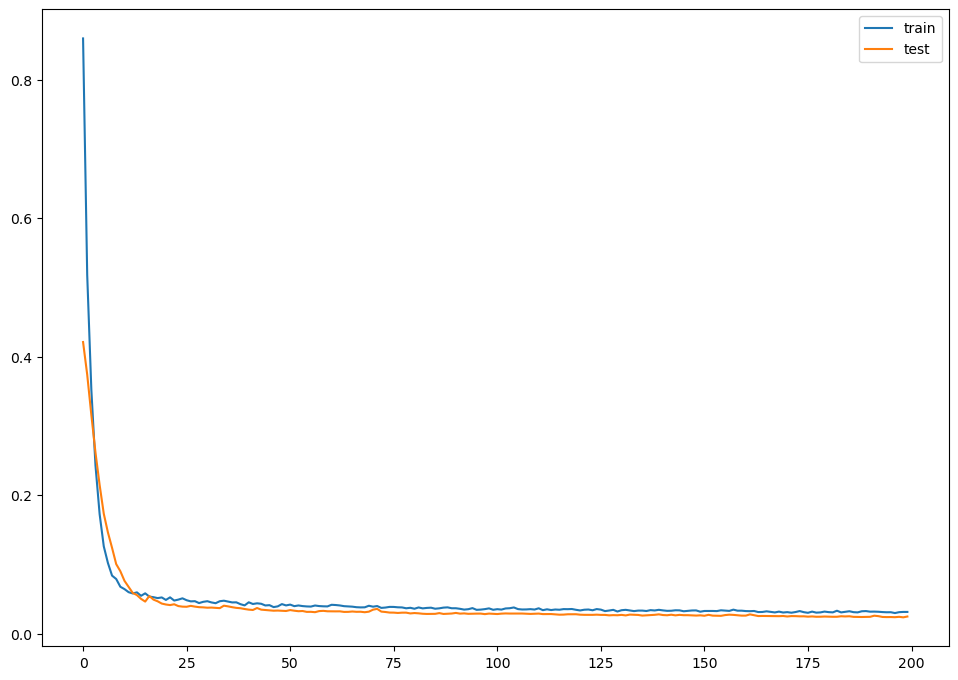

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
14/14 [==============================] - 0s 1ms/step


In [41]:
BF_CTU_df_autoencoder = perform_feature_extraction(BF_CTU_df, 0.5, epochs=200, df_name="BF_CTU_autoencoder")

In [ ]:
compare_clfs(BF_CTU_df_autoencoder, df_name="BF_CTU_autoencoder")

Cross-Validated F1-Score - Logistic Regression: 0.8155874933645693


-----here, only the f1 score of LR is possible?

# Experimental results for all the datasets

In this section we are going to compare the Relative Shap Value Contribution for each machine learning method and feature selection method (PCA, Sparse-PCA, and Autoencoder) accross all the available datasets.

## Baseline Results

The following code runs 4 different estimators (Logistic Regression, Random Forest, SVM and XGBoost) for all the datasets. It also creates plots comparing the Shap values for each model.

Be aware that running all experiments at once may take a while. For this reason we did it just once and save the plots and results in a csv. In the next cells we are going to look at each of these results.

In [ ]:
BF_CTU_df_perf_df = compare_clfs(BF_CTU_df, df_name="BF_CTU_df", plot_name="baseline_shap_comparison_BF_CTU_df", path="plots/baseline", return_performance_df=True)
BF_OU_df_perf_df = compare_clfs(BF_OU_df, df_name="BF_OU_df", plot_name="baseline_shap_comparison_BF_OU_df", path="plots/baseline", return_performance_df=True)
BF_V_df_perf_df = compare_clfs(BF_V_df, df_name="BF_V_df", plot_name="baseline_shap_comparison_BF_V_df", path="plots/baseline", return_performance_df=True)
DT_CC_df_perf_df = compare_clfs(DT_CC_df, df_name="DT_CC_df", plot_name="baseline_shap_comparison_DT_CC_df", path="plots/baseline", return_performance_df=True)
DT_JI_df_perf_df = compare_clfs(DT_JI_df, df_name="DT_JI_df", plot_name="baseline_shap_comparison_DT_JI_df", path="plots/baseline", return_performance_df=True)
IADQ_df_perf_df = compare_clfs(IADQ_df, df_name="IADQ_df", plot_name="baseline_shap_comparison_IADQ_df", path="plots/baseline", return_performance_df=True)
IESR_df_perf_df = compare_clfs(IESR_df, df_name="IESR_df", plot_name="baseline_shap_comparison_IESR_df", path="plots/baseline", return_performance_df=True)
NAQR_df_perf_df = compare_clfs(NAQR_df, df_name="NAQR_df", plot_name="baseline_shap_comparison_NAQR_df", path="plots/baseline", return_performance_df=True)
PCL5_df_perf_df = compare_clfs(PCL5_df, df_name="PCL5_df", plot_name="baseline_shap_comparison_PCL5_df", path="plots/baseline", return_performance_df=True)
PHQ9_df_perf_df = compare_clfs(PHQ9_df, df_name="PHQ9_df", plot_name="baseline_shap_comparison_PHQ9_df", path="plots/baseline", return_performance_df=True)
PID5_df_perf_df = compare_clfs(PID5_df, df_name="PID5_df", plot_name="baseline_shap_comparison_PID5_df", path="plots/baseline", return_performance_df=True)
PRFQ_df_perf_df = compare_clfs(PRFQ_df, df_name="PRFQ_df", plot_name="baseline_shap_comparison_PRFQ_df", path="plots/baseline", return_performance_df=True)
PRMQ_df_perf_df = compare_clfs(PRMQ_df, df_name="PRMQ_df", plot_name="baseline_shap_comparison_PRMQ_df", path="plots/baseline", return_performance_df=True)
DDDT_df_perf_df = compare_clfs(DDDT_df, df_name="DDDT_df", plot_name="baseline_shap_comparison_DDDT_df", path="plots/baseline", return_performance_df=True)
SPID5_df_perf_df = compare_clfs(SPID5_df, df_name="SPID5_df", plot_name="baseline_shap_comparison_SPID5_df", path="plots/baseline", return_performance_df=True)
RNEOPI_df_perf_df = compare_clfs(RNEOPI_df, df_name="RNEOPI_df", plot_name="baseline_shap_comparison_RNEOPI_df", path="plots/baseline", return_performance_df=True)

In [2]:
# Creating a dataframe to store the resultls and save them as a csv
baseline_results_df = pd.concat([BF_CTU_df_perf_df, 
                                 BF_OU_df_perf_df, 
                                 BF_V_df_perf_df, 
                                 DT_CC_df_perf_df, 
                                 DT_JI_df_perf_df, 
                                 IADQ_df_perf_df, 
                                 IESR_df_perf_df, 
                                 NAQR_df_perf_df, 
                                 PCL5_df_perf_df, 
                                 PHQ9_df_perf_df, 
                                 PID5_df_perf_df, 
                                 PRFQ_df_perf_df, 
                                 PRMQ_df_perf_df, 
                                 DDDT_df_perf_df, 
                                 SPID5_df_perf_df, 
                                 RNEOPI_df_perf_df])
baseline_results_df.to_csv("results/results_baseline.csv", index=False)

NameError: name 'pd' is not defined

### Summary Table: Baseline (No preprocessing)

In [4]:
results = pd.read_csv("results/results_baseline.csv")
results.pivot(index='Dataset', columns='Model', values='F1')

Model,lr,rf,svm,xgboost
Dataset,,,,
BF_CTU_df,0.81,0.83,0.82,0.81
BF_OU_df,0.83,0.84,0.84,0.82
BF_V_df,0.79,0.83,0.79,0.81
DDDT_df,0.76,0.79,0.76,0.78
DT_CC_df,0.73,0.77,0.75,0.73
DT_JI_df,0.66,0.60,0.67,0.61
IADQ_df,0.83,0.83,0.84,0.80
IESR_df,0.92,0.95,0.93,0.93
NAQR_df,0.91,0.92,0.93,0.90


### Relative Shap Value Comparinson: Baseline (No Preprocessing)

Column 1  | Column 2
- | - 
![baseline_shap_comparison_BF_CTU](plots/baseline/baseline_shap_comparison_BF_CTU_df.png) | ![baseline_shap_comparison_BF_OU](plots/baseline/baseline_shap_comparison_BF_OU_df.png)
![baseline_shap_comparison_BF_V](plots/baseline/baseline_shap_comparison_BF_V_df.png) | ![baseline_shap_comparison_DT_CC](plots/baseline/baseline_shap_comparison_DT_CC_df.png)
![baseline_shap_comparison_DT_JI](plots/baseline/baseline_shap_comparison_DT_JI_df.png) | ![baseline_shap_comparison_IADQ](plots/baseline/baseline_shap_comparison_IADQ_df.png)
![baseline_shap_comparison_IESR](plots/baseline/baseline_shap_comparison_IESR_df.png) | ![baseline_shap_comparison_NAQR](plots/baseline/baseline_shap_comparison_NAQR_df.png)
![baseline_shap_comparison_PCL5](plots/baseline/baseline_shap_comparison_PCL5_df.png) | ![baseline_shap_comparison_PHQ9](plots/baseline/baseline_shap_comparison_PHQ9_df.png)
![baseline_shap_comparison_PID5](plots/baseline/baseline_shap_comparison_PID5_df.png) | ![baseline_shap_comparison_PRFQ](plots/baseline/baseline_shap_comparison_PRFQ_df.png)
![baseline_shap_comparison_PRMQ](plots/baseline/baseline_shap_comparison_PRMQ_df.png) | ![baseline_shap_comparison_DDDT](plots/baseline/baseline_shap_comparison_DDDT_df.png)
![baseline_shap_comparison_SPID5](plots/baseline/baseline_shap_comparison_SPID5_df.png) | ![baseline_shap_comparison_RNEOPI](plots/baseline/baseline_shap_comparison_RNEOPI_df.png)

## Feature Selection: PCA Results

In [ ]:
BF_CTU_df_pca = perform_pca(BF_CTU_df, 0.2)
BF_CTU_df_perf_df = compare_clfs(BF_CTU_df_pca, df_name="BF_CTU_df_pca", plot_name="pca_shap_comparison_BF_CTU_df", path="plots/pca", return_performance_df=True)

BF_OU_df_pca = perform_pca(BF_OU_df, 0.2)
BF_OU_df_perf_df = compare_clfs(BF_OU_df_pca, df_name="BF_OU_df_pca", plot_name="pca_shap_comparison_BF_OU_df", path="plots/pca", return_performance_df=True)

BF_V_df_pca = perform_pca(BF_V_df, 0.2)
BF_V_df_perf_df = compare_clfs(BF_V_df_pca, df_name="BF_V_df_pca", plot_name="pca_shap_comparison_BF_V_df", path="plots/pca", return_performance_df=True)

DT_CC_df_pca = perform_pca(DT_CC_df, 0.2)
DT_CC_df_perf_df = compare_clfs(DT_CC_df_pca, df_name="DT_CC_df_pca", plot_name="pca_shap_comparison_DT_CC_df", path="plots/pca", return_performance_df=True)

DT_JI_df_pca = perform_pca(DT_JI_df, 0.2)
DT_JI_df_perf_df = compare_clfs(DT_JI_df_pca, df_name="DT_JI_df_pca", plot_name="pca_shap_comparison_DT_JI_df", path="plots/pca", return_performance_df=True)

IADQ_df_pca = perform_pca(IADQ_df, 0.2)
IADQ_df_perf_df = compare_clfs(IADQ_df_pca, df_name="IADQ_df_pca", plot_name="pca_shap_comparison_IADQ_df", path="plots/pca", return_performance_df=True)

IESR_df_pca = perform_pca(IESR_df, 0.2)
IESR_df_perf_df = compare_clfs(IESR_df_pca, df_name="IESR_df_pca", plot_name="pca_shap_comparison_IESR_df", path="plots/pca", return_performance_df=True)

NAQR_df_pca = perform_pca(NAQR_df, 0.2)
NAQR_df_perf_df = compare_clfs(NAQR_df_pca, df_name="NAQR_df_pca", plot_name="pca_shap_comparison_NAQR_df", path="plots/pca", return_performance_df=True)

PCL5_df_pca = perform_pca(PCL5_df, 0.2)
PCL5_df_perf_df = compare_clfs(PCL5_df_pca, df_name="PCL5_df_pca", plot_name="pca_shap_comparison_PCL5_df", path="plots/pca", return_performance_df=True)

PHQ9_df_pca = perform_pca(PHQ9_df, 0.2)
PHQ9_df_perf_df = compare_clfs(PHQ9_df_pca, df_name="PHQ9_df_pca", plot_name="pca_shap_comparison_PHQ9_df", path="plots/pca", return_performance_df=True)

PID5_df_pca = perform_pca(PID5_df, 0.2)
PID5_df_perf_df = compare_clfs(PID5_df_pca, df_name="PID5_df_pca", plot_name="pca_shap_comparison_PID5_df", path="plots/pca", return_performance_df=True)

PRFQ_df_pca = perform_pca(PRFQ_df, 0.2)
PRFQ_df_perf_df = compare_clfs(PRFQ_df_pca, df_name="PRFQ_df_pca", plot_name="pca_shap_comparison_PRFQ_df", path="plots/pca", return_performance_df=True)

PRMQ_df_pca = perform_pca(PRMQ_df, 0.2)
PRMQ_df_perf_df = compare_clfs(PRMQ_df_pca, df_name="PRMQ_df_pca", plot_name="pca_shap_comparison_PRMQ_df", path="plots/pca", return_performance_df=True)

DDDT_df_pca = perform_pca(DDDT_df, 0.2)
DDDT_df_perf_df = compare_clfs(DDDT_df_pca, df_name="DDDT_df_pca", plot_name="pca_shap_comparison_DDDT_df", path="plots/pca", return_performance_df=True)

SPID5_df_pca = perform_pca(SPID5_df, 0.2)
SPID5_df_perf_df = compare_clfs(SPID5_df_pca, df_name="SPID5_df_pca", plot_name="pca_shap_comparison_SPID5_df", path="plots/pca", return_performance_df=True)

RNEOPI_df_pca = perform_pca(RNEOPI_df, 0.2)
RNEOPI_df_perf_df = compare_clfs(RNEOPI_df_pca, df_name="RNEOPI_df_pca", plot_name="pca_shap_comparison_RNEOPI_df", path="plots/pca", return_performance_df=True)

In [ ]:
# Create a dataframe to store the resultls and save them as a csv
pca_results_df = pd.concat([BF_CTU_df_perf_df, 
                                 BF_OU_df_perf_df, 
                                 BF_V_df_perf_df, 
                                 DT_CC_df_perf_df, 
                                 DT_JI_df_perf_df, 
                                 IADQ_df_perf_df, 
                                 IESR_df_perf_df, 
                                 NAQR_df_perf_df, 
                                 PCL5_df_perf_df, 
                                 PHQ9_df_perf_df, 
                                 PID5_df_perf_df, 
                                 PRFQ_df_perf_df, 
                                 PRMQ_df_perf_df, 
                                 DDDT_df_perf_df, 
                                 SPID5_df_perf_df, 
                                 RNEOPI_df_perf_df])
pca_results_df.to_csv("results/results_pca.csv", index=False)

### Summary Table: Feature Selection with PCA

In [16]:
results = pd.read_csv("results/results_pca.csv")
results.pivot(index='Dataset', columns='Model', values='F1')

Model,lr,rf,svm,xgboost
Dataset,,,,
BF_CTU_df_pca,0.81,0.77,0.81,0.72
BF_OU_df_pca,0.81,0.77,0.81,0.72
BF_V_df_pca,0.81,0.77,0.81,0.72
DDDT_df_pca,0.81,0.77,0.81,0.72
DT_CC_df_pca,0.81,0.77,0.81,0.72
DT_JI_df_pca,0.81,0.77,0.81,0.72
IADQ_df_pca,0.81,0.77,0.81,0.72
IESR_df_pca,0.81,0.77,0.81,0.72
NAQR_df_pca,0.81,0.77,0.81,0.72


### Relative Shap Value Comparison: Feature Selection with PCA

Column 1 | Column 2
- | - 
![pca_shap_comparison_BF_CTU](plots/pca/pca_shap_comparison_BF_CTU_df.png) | ![pca_shap_comparison_BF_OU](plots/pca/pca_shap_comparison_BF_OU_df.png)
![pca_shap_comparison_BF_V](plots/pca/pca_shap_comparison_BF_V_df.png) | ![pca_shap_comparison_DT_CC](plots/pca/pca_shap_comparison_DT_CC_df.png)
![pca_shap_comparison_DT_JI](plots/pca/pca_shap_comparison_DT_JI_df.png) | ![pca_shap_comparison_IADQ](plots/pca/pca_shap_comparison_IADQ_df.png)
![pca_shap_comparison_IESR](plots/pca/pca_shap_comparison_IESR_df.png) | ![pca_shap_comparison_NAQR](plots/pca/pca_shap_comparison_NAQR_df.png)
![pca_shap_comparison_PCL5](plots/pca/pca_shap_comparison_PCL5_df.png) | ![pca_shap_comparison_PHQ9](plots/pca/pca_shap_comparison_PHQ9_df.png)
![pca_shap_comparison_PID5](plots/pca/pca_shap_comparison_PID5_df.png) | ![pca_shap_comparison_PRFQ](plots/pca/pca_shap_comparison_PRFQ_df.png)
![pca_shap_comparison_PRMQ](plots/pca/pca_shap_comparison_PRMQ_df.png) | ![pca_shap_comparison_DDDT](plots/pca/pca_shap_comparison_DDDT_df.png)
![pca_shap_comparison_SPID5](plots/pca/pca_shap_comparison_SPID5_df.png) | ![pca_shap_comparison_RNEOPI](plots/pca/pca_shap_comparison_RNEOPI_df.png)

## Feature Selection: Sparse-PCA Results

In [ ]:
BF_CTU_df_spca = perform_sparce_pca(BF_CTU_df, 0.2)
BF_CTU_df_perf_df = compare_clfs(BF_CTU_df_spca, df_name="BF_CTU_df_spca", plot_name="spca_shap_comparison_BF_CTU_df", path="plots/sparse_pca", return_performance_df=True)

BF_OU_df_spca = perform_sparce_pca(BF_OU_df, 0.2)
BF_OU_df_perf_df = compare_clfs(BF_OU_df_spca, df_name="BF_OU_df_spca", plot_name="spca_shap_comparison_BF_OU_df", path="plots/sparse_pca", return_performance_df=True)

BF_V_df_spca = perform_sparce_pca(BF_V_df, 0.2)
BF_V_df_perf_df = compare_clfs(BF_V_df_spca, df_name="BF_V_df_spca", plot_name="spca_shap_comparison_BF_V_df", path="plots/sparse_pca", return_performance_df=True)

DT_CC_df_spca = perform_sparce_pca(DT_CC_df, 0.2)
DT_CC_df_perf_df = compare_clfs(DT_CC_df_spca, df_name="DT_CC_df_spca", plot_name="spca_shap_comparison_DT_CC_df", path="plots/sparse_pca", return_performance_df=True)

DT_JI_df_spca = perform_sparce_pca(DT_JI_df, 0.2)
DT_JI_df_perf_df = compare_clfs(DT_JI_df_spca, df_name="DT_JI_df_spca", plot_name="spca_shap_comparison_DT_JI_df", path="plots/sparse_pca", return_performance_df=True)

IADQ_df_spca = perform_sparce_pca(IADQ_df, 0.2)
IADQ_df_perf_df = compare_clfs(IADQ_df_spca, df_name="IADQ_df_spca", plot_name="spca_shap_comparison_IADQ_df", path="plots/sparse_pca", return_performance_df=True)

IESR_df_spca = perform_sparce_pca(IESR_df, 0.2)
IESR_df_perf_df = compare_clfs(IESR_df_spca, df_name="IESR_df_spca", plot_name="spca_shap_comparison_IESR_df", path="plots/sparse_pca", return_performance_df=True)

NAQR_df_spca = perform_sparce_pca(NAQR_df, 0.2)
NAQR_df_perf_df = compare_clfs(NAQR_df_spca, df_name="NAQR_df_spca", plot_name="spca_shap_comparison_NAQR_df", path="plots/sparse_pca", return_performance_df=True)

PCL5_df_spca = perform_sparce_pca(PCL5_df, 0.2)
PCL5_df_perf_df = compare_clfs(PCL5_df_spca, df_name="PCL5_df_spca", plot_name="spca_shap_comparison_PCL5_df", path="plots/sparse_pca", return_performance_df=True)

PHQ9_df_spca = perform_sparce_pca(PHQ9_df, 0.2)
PHQ9_df_perf_df = compare_clfs(PHQ9_df_spca, df_name="PHQ9_df_spca", plot_name="spca_shap_comparison_PHQ9_df", path="plots/sparse_pca", return_performance_df=True)

PID5_df_spca = perform_sparce_pca(PID5_df, 0.2)
PID5_df_perf_df = compare_clfs(PID5_df_spca, df_name="PID5_df_spca", plot_name="spca_shap_comparison_PID5_df", path="plots/sparse_pca", return_performance_df=True)

PRFQ_df_spca = perform_sparce_pca(PRFQ_df, 0.2)
PRFQ_df_perf_df = compare_clfs(PRFQ_df_spca, df_name="PRFQ_df_spca", plot_name="spca_shap_comparison_PRFQ_df", path="plots/sparse_pca", return_performance_df=True)

PRMQ_df_spca = perform_sparce_pca(PRMQ_df, 0.2)
PRMQ_df_perf_df = compare_clfs(PRMQ_df_spca, df_name="PRMQ_df_spca", plot_name="spca_shap_comparison_PRMQ_df", path="plots/sparse_pca", return_performance_df=True)

DDDT_df_spca = perform_sparce_pca(DDDT_df, 0.2)
DDDT_df_perf_df = compare_clfs(DDDT_df_spca, df_name="DDDT_df_spca", plot_name="spca_shap_comparison_DDDT_df", path="plots/sparse_pca", return_performance_df=True)

SPID5_df_spca = perform_sparce_pca(SPID5_df, 0.2)
SPID5_df_perf_df = compare_clfs(SPID5_df_spca, df_name="SPID5_df_spca", plot_name="spca_shap_comparison_SPID5_df", path="plots/sparse_pca", return_performance_df=True)

In [14]:
# Creating a dataframe to store the resultls and save them as a csv
sparse_pca_results_df = pd.concat([BF_CTU_df_perf_df, 
                                 BF_OU_df_perf_df, 
                                 BF_V_df_perf_df, 
                                 DT_CC_df_perf_df, 
                                 DT_JI_df_perf_df, 
                                 IADQ_df_perf_df, 
                                 IESR_df_perf_df, 
                                 NAQR_df_perf_df, 
                                 PCL5_df_perf_df, 
                                 PHQ9_df_perf_df, 
                                 PID5_df_perf_df, 
                                 PRFQ_df_perf_df, 
                                 PRMQ_df_perf_df, 
                                 DDDT_df_perf_df, 
                                 SPID5_df_perf_df])
sparse_pca_results_df.to_csv("results/results_spca.csv", index=False)

### Summary Table: Feature Selection with Sparse-PCA

In [15]:
results = pd.read_csv("results/results_spca.csv")
results.pivot(index='Dataset', columns='Model', values='F1')

Model,lr,rf,svm,xgboost
Dataset,,,,
BF_CTU_df_spca,0.81,0.80,0.81,0.78
BF_OU_df_spca,0.81,0.80,0.80,0.78
BF_V_df_spca,0.82,0.81,0.82,0.81
DDDT_df_spca,0.74,0.73,0.75,0.69
DT_CC_df_spca,0.73,0.77,0.75,0.75
DT_JI_df_spca,0.64,0.56,0.66,0.60
IADQ_df_spca,0.83,0.81,0.83,0.81
IESR_df_spca,0.94,0.95,0.94,0.93
NAQR_df_spca,0.94,0.93,0.96,0.91


### Relative Shap Value Comparison: Feature Selection with Sparse-PCA

Column 1 | Column 2
- | - 
![spca_shap_comparison_BF_CTU](plots/sparse_pca/spca_shap_comparison_BF_CTU_df.png) | ![spca_shap_comparison_BF_OU](plots/sparse_pca/spca_shap_comparison_BF_OU_df.png)
![spca_shap_comparison_BF_V](plots/sparse_pca/spca_shap_comparison_BF_V_df.png) | ![spca_shap_comparison_DT_CC](plots/sparse_pca/spca_shap_comparison_DT_CC_df.png)
![spca_shap_comparison_DT_JI](plots/sparse_pca/spca_shap_comparison_DT_JI_df.png) | ![spca_shap_comparison_IADQ](plots/sparse_pca/spca_shap_comparison_IADQ_df.png)
![spca_shap_comparison_IESR](plots/sparse_pca/spca_shap_comparison_IESR_df.png) | ![spca_shap_comparison_NAQR](plots/sparse_pca/spca_shap_comparison_NAQR_df.png)
![spca_shap_comparison_PCL5](plots/sparse_pca/spca_shap_comparison_PCL5_df.png) | ![spca_shap_comparison_PHQ9](plots/sparse_pca/spca_shap_comparison_PHQ9_df.png)
![spca_shap_comparison_PID5](plots/sparse_pca/spca_shap_comparison_PID5_df.png) | ![spca_shap_comparison_PRFQ](plots/sparse_pca/spca_shap_comparison_PRFQ_df.png)
![spca_shap_comparison_PRMQ](plots/sparse_pca/spca_shap_comparison_PRMQ_df.png) | ![spca_shap_comparison_DDDT](plots/sparse_pca/spca_shap_comparison_DDDT_df.png)
![spca_shap_comparison_SPID5](plots/sparse_pca/spca_shap_comparison_SPID5_df.png) |

## Feature Selection: Autoencoder Results

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
23/23 - 1s - loss: 0.7296 - val_loss: 0.4473 - 688ms/epoch - 30ms/step
Epoch 2/200
23/23 - 0s - loss: 0.4699 - val_loss: 0.3923 - 46ms/epoch - 2ms/step
Epoch 3/200
23/23 - 0s - loss: 0.3322 - val_loss: 0.3426 - 43ms/epoch - 2ms/step
Epoch 4/200
23/23 - 0s - loss: 0.2476 - val_loss: 0.2898 - 43ms/epoch - 2ms/step
Epoch 5/200
23/23 - 0s - loss: 0.1812 - val_loss: 0.2515 - 40ms/epoch - 2ms/step
Epoch 6/200
23/23 - 0s - loss: 0.1442 - val_loss: 0.2183 - 39ms/epoch - 2ms/step
Epoch 7/200
23/23 - 0s - loss: 0.1223 - val_loss: 0.1921 - 42ms/epoch - 2ms/step
Epoch 8/200
23/23 - 0s - loss: 0.1084 - val_loss: 0.1652 - 43ms/epoch - 2ms/step
Epoch 9/200
23/23 - 0s - loss: 0.0924 - val_loss: 0.1387 - 37ms/epoch - 2ms/step
Epoch 10/200
23/23 - 0s - loss: 0.0826 - val_loss: 0.1162 - 40ms/epoch - 2ms/step
Epoch 11/200
23/23 - 0s -

23/23 - 0s - loss: 0.0460 - val_loss: 0.0406 - 39ms/epoch - 2ms/step
Epoch 100/200
23/23 - 0s - loss: 0.0445 - val_loss: 0.0392 - 36ms/epoch - 2ms/step
Epoch 101/200
23/23 - 0s - loss: 0.0451 - val_loss: 0.0382 - 37ms/epoch - 2ms/step
Epoch 102/200
23/23 - 0s - loss: 0.0431 - val_loss: 0.0384 - 36ms/epoch - 2ms/step
Epoch 103/200
23/23 - 0s - loss: 0.0440 - val_loss: 0.0381 - 37ms/epoch - 2ms/step
Epoch 104/200
23/23 - 0s - loss: 0.0432 - val_loss: 0.0371 - 37ms/epoch - 2ms/step
Epoch 105/200
23/23 - 0s - loss: 0.0433 - val_loss: 0.0376 - 37ms/epoch - 2ms/step
Epoch 106/200
23/23 - 0s - loss: 0.0431 - val_loss: 0.0376 - 37ms/epoch - 2ms/step
Epoch 107/200
23/23 - 0s - loss: 0.0431 - val_loss: 0.0375 - 38ms/epoch - 2ms/step
Epoch 108/200
23/23 - 0s - loss: 0.0425 - val_loss: 0.0372 - 37ms/epoch - 2ms/step
Epoch 109/200
23/23 - 0s - loss: 0.0437 - val_loss: 0.0371 - 37ms/epoch - 2ms/step
Epoch 110/200
23/23 - 0s - loss: 0.0420 - val_loss: 0.0374 - 38ms/epoch - 2ms/step
Epoch 111/200
23/2

Epoch 198/200
23/23 - 0s - loss: 0.0416 - val_loss: 0.0362 - 42ms/epoch - 2ms/step
Epoch 199/200
23/23 - 0s - loss: 0.0412 - val_loss: 0.0356 - 40ms/epoch - 2ms/step
Epoch 200/200
23/23 - 0s - loss: 0.0409 - val_loss: 0.0374 - 40ms/epoch - 2ms/step


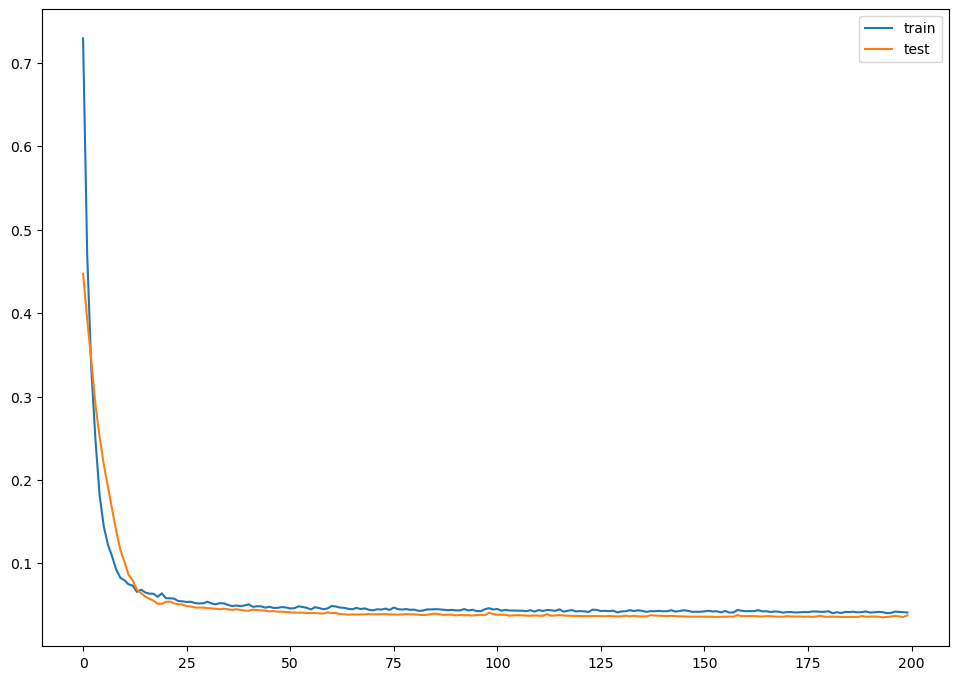

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
14/14 [==============================] - 0s 529us/step
Cross-Validated F1-Score - Logistic Regression: 0.8286775040670988
Cross-Validated F1-Score - Random Forest: 0.8254507959349155
Cross-Validated F1-Score - SVM: 0.8316466138732345
Cross-Validated F1-Score - XGBoost: 0.7940930558070376


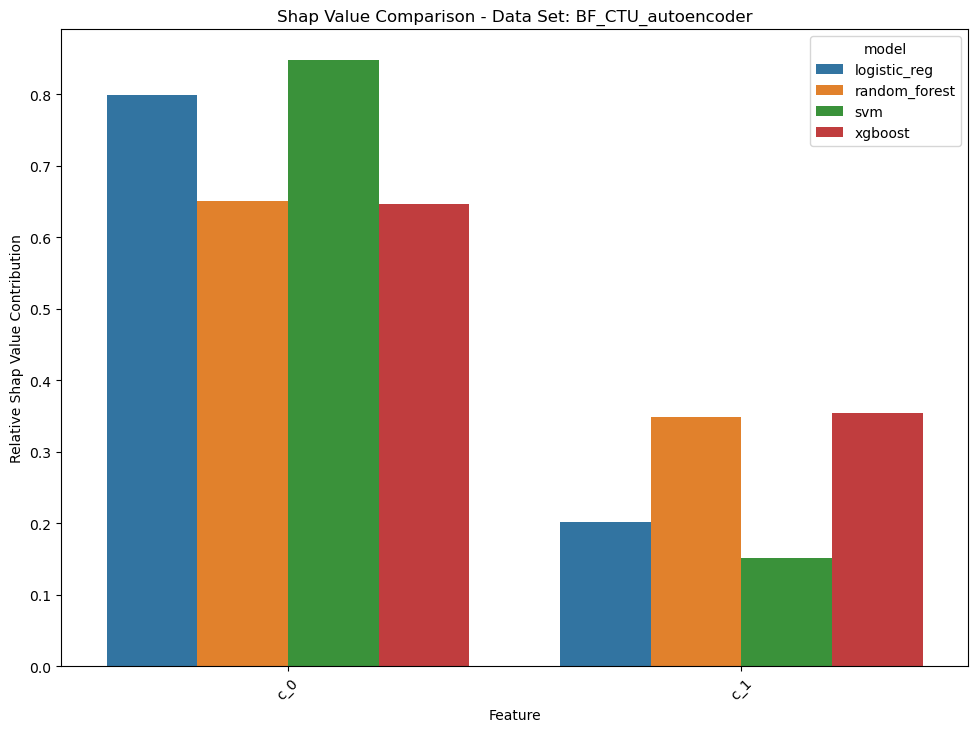

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
25/25 - 1s - loss: 0.6128 - val_loss: 0.1864 - 663ms/epoch - 27ms/step
Epoch 2/200
25/25 - 0s - loss: 0.2320 - val_loss: 0.1475 - 45ms/epoch - 2ms/step
Epoch 3/200
25/25 - 0s - loss: 0.1368 - val_loss: 0.1203 - 45ms/epoch - 2ms/step
Epoch 4/200
25/25 - 0s - loss: 0.1024 - val_loss: 0.1011 - 43ms/epoch - 2ms/step
Epoch 5/200
25/25 - 0s - loss: 0.0865 - val_loss: 0.0860 - 38ms/epoch - 2ms/step
Epoch 6/200
25/25 - 0s - loss: 0.0803 - val_loss: 0.0741 - 38ms/epoch - 2ms/step
Epoch 7/200
25/25 - 0s - loss: 0.0750 - val_loss: 0.0666 - 40ms/epoch - 2ms/step
Epoch 8/200
25/25 - 0s - loss: 0.0684 - val_loss: 0.0611 - 40ms/epoch - 2ms/step
Epoch 9/200
25/25 - 0s - loss: 0.0680 - val_loss: 0.0578 - 39ms/epoch - 2ms/step
Epoch 10/200
25/25 - 0s - loss: 0.0632 - val_loss: 0.0551 - 40ms/epoch - 2ms/step
Epoch 11/200
25/25 - 0s -

25/25 - 0s - loss: 0.0438 - val_loss: 0.0383 - 40ms/epoch - 2ms/step
Epoch 100/200
25/25 - 0s - loss: 0.0430 - val_loss: 0.0384 - 42ms/epoch - 2ms/step
Epoch 101/200
25/25 - 0s - loss: 0.0439 - val_loss: 0.0382 - 39ms/epoch - 2ms/step
Epoch 102/200
25/25 - 0s - loss: 0.0425 - val_loss: 0.0385 - 38ms/epoch - 2ms/step
Epoch 103/200
25/25 - 0s - loss: 0.0432 - val_loss: 0.0381 - 40ms/epoch - 2ms/step
Epoch 104/200
25/25 - 0s - loss: 0.0435 - val_loss: 0.0385 - 39ms/epoch - 2ms/step
Epoch 105/200
25/25 - 0s - loss: 0.0430 - val_loss: 0.0386 - 42ms/epoch - 2ms/step
Epoch 106/200
25/25 - 0s - loss: 0.0427 - val_loss: 0.0379 - 39ms/epoch - 2ms/step
Epoch 107/200
25/25 - 0s - loss: 0.0424 - val_loss: 0.0377 - 37ms/epoch - 1ms/step
Epoch 108/200
25/25 - 0s - loss: 0.0420 - val_loss: 0.0376 - 39ms/epoch - 2ms/step
Epoch 109/200
25/25 - 0s - loss: 0.0425 - val_loss: 0.0373 - 40ms/epoch - 2ms/step
Epoch 110/200
25/25 - 0s - loss: 0.0427 - val_loss: 0.0374 - 42ms/epoch - 2ms/step
Epoch 111/200
25/2

Epoch 198/200
25/25 - 0s - loss: 0.0402 - val_loss: 0.0353 - 39ms/epoch - 2ms/step
Epoch 199/200
25/25 - 0s - loss: 0.0395 - val_loss: 0.0350 - 38ms/epoch - 2ms/step
Epoch 200/200
25/25 - 0s - loss: 0.0386 - val_loss: 0.0346 - 39ms/epoch - 2ms/step


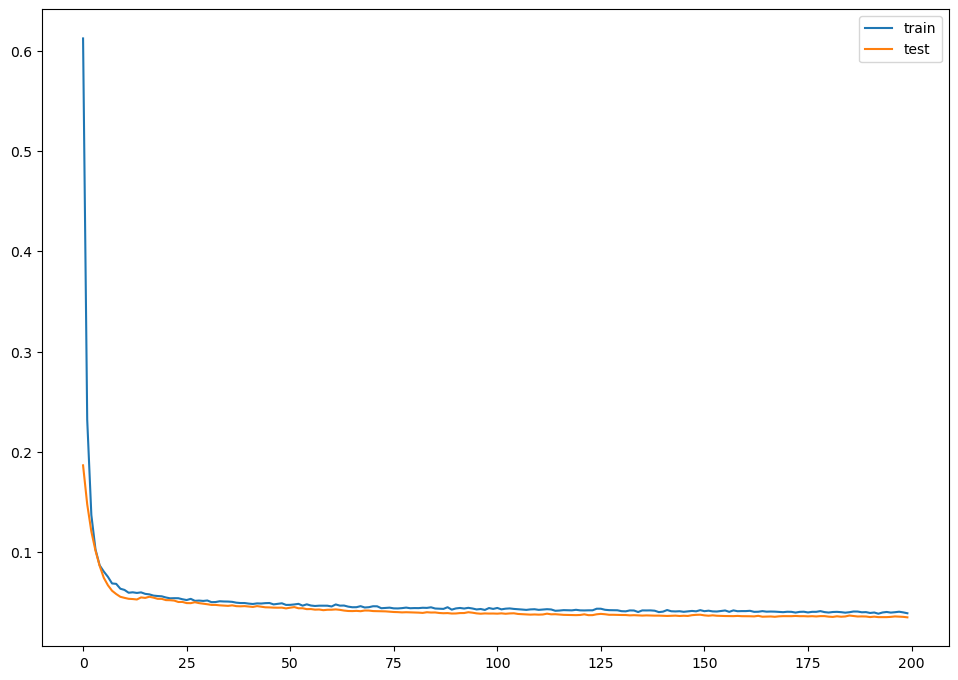

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
16/16 [==============================] - 0s 539us/step
Cross-Validated F1-Score - Logistic Regression: 0.715788084464555
Cross-Validated F1-Score - Random Forest: 0.7360535866558251
Cross-Validated F1-Score - SVM: 0.7262132900714553
Cross-Validated F1-Score - XGBoost: 0.6711121624285432


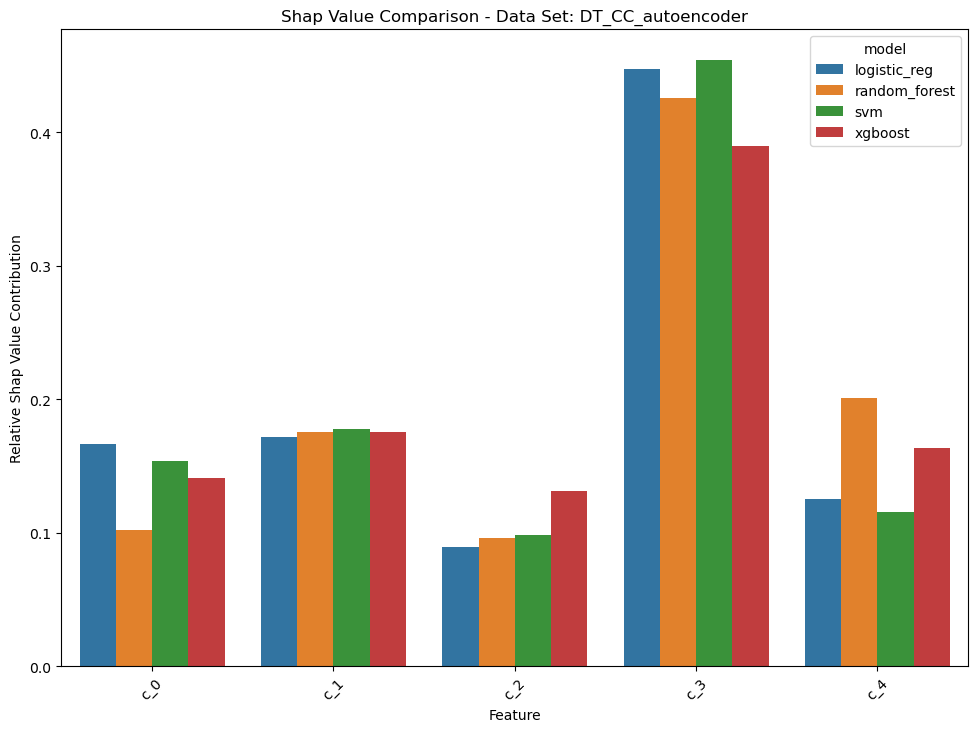

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
44/44 - 1s - loss: 0.3619 - val_loss: 0.1808 - 921ms/epoch - 21ms/step
Epoch 2/200
44/44 - 0s - loss: 0.0993 - val_loss: 0.1230 - 75ms/epoch - 2ms/step
Epoch 3/200
44/44 - 0s - loss: 0.0696 - val_loss: 0.0991 - 65ms/epoch - 1ms/step
Epoch 4/200
44/44 - 0s - loss: 0.0606 - val_loss: 0.0761 - 61ms/epoch - 1ms/step
Epoch 5/200
44/44 - 0s - loss: 0.0548 - val_loss: 0.0612 - 62ms/epoch - 1ms/step
Epoch 6/200
44/44 - 0s - loss: 0.0523 - val_loss: 0.0547 - 66ms/epoch - 2ms/step
Epoch 7/200
44/44 - 0s - loss: 0.0511 - val_loss: 0.0488 - 63ms/epoch - 1ms/step
Epoch 8/200
44/44 - 0s - loss: 0.0499 - val_loss: 0.0472 - 76ms/epoch - 2ms/step
Epoch 9/200
44/44 - 0s - loss: 0.0480 - val_loss: 0.0473 - 62ms/epoch - 1ms/step
Epoch 10/200
44/44 - 0s - loss: 0.0472 - val_loss: 0.0448 - 61ms/epoch - 1ms/step
Epoch 11/200
44/44 - 0s -

44/44 - 0s - loss: 0.0357 - val_loss: 0.0354 - 62ms/epoch - 1ms/step
Epoch 100/200
44/44 - 0s - loss: 0.0358 - val_loss: 0.0356 - 63ms/epoch - 1ms/step
Epoch 101/200
44/44 - 0s - loss: 0.0352 - val_loss: 0.0348 - 66ms/epoch - 2ms/step
Epoch 102/200
44/44 - 0s - loss: 0.0354 - val_loss: 0.0353 - 62ms/epoch - 1ms/step
Epoch 103/200
44/44 - 0s - loss: 0.0352 - val_loss: 0.0354 - 63ms/epoch - 1ms/step
Epoch 104/200
44/44 - 0s - loss: 0.0350 - val_loss: 0.0354 - 62ms/epoch - 1ms/step
Epoch 105/200
44/44 - 0s - loss: 0.0352 - val_loss: 0.0346 - 60ms/epoch - 1ms/step
Epoch 106/200
44/44 - 0s - loss: 0.0354 - val_loss: 0.0349 - 62ms/epoch - 1ms/step
Epoch 107/200
44/44 - 0s - loss: 0.0354 - val_loss: 0.0355 - 63ms/epoch - 1ms/step
Epoch 108/200
44/44 - 0s - loss: 0.0349 - val_loss: 0.0347 - 61ms/epoch - 1ms/step
Epoch 109/200
44/44 - 0s - loss: 0.0351 - val_loss: 0.0346 - 58ms/epoch - 1ms/step
Epoch 110/200
44/44 - 0s - loss: 0.0346 - val_loss: 0.0348 - 60ms/epoch - 1ms/step
Epoch 111/200
44/4

Epoch 198/200
44/44 - 0s - loss: 0.0337 - val_loss: 0.0344 - 63ms/epoch - 1ms/step
Epoch 199/200
44/44 - 0s - loss: 0.0335 - val_loss: 0.0347 - 60ms/epoch - 1ms/step
Epoch 200/200
44/44 - 0s - loss: 0.0336 - val_loss: 0.0341 - 61ms/epoch - 1ms/step


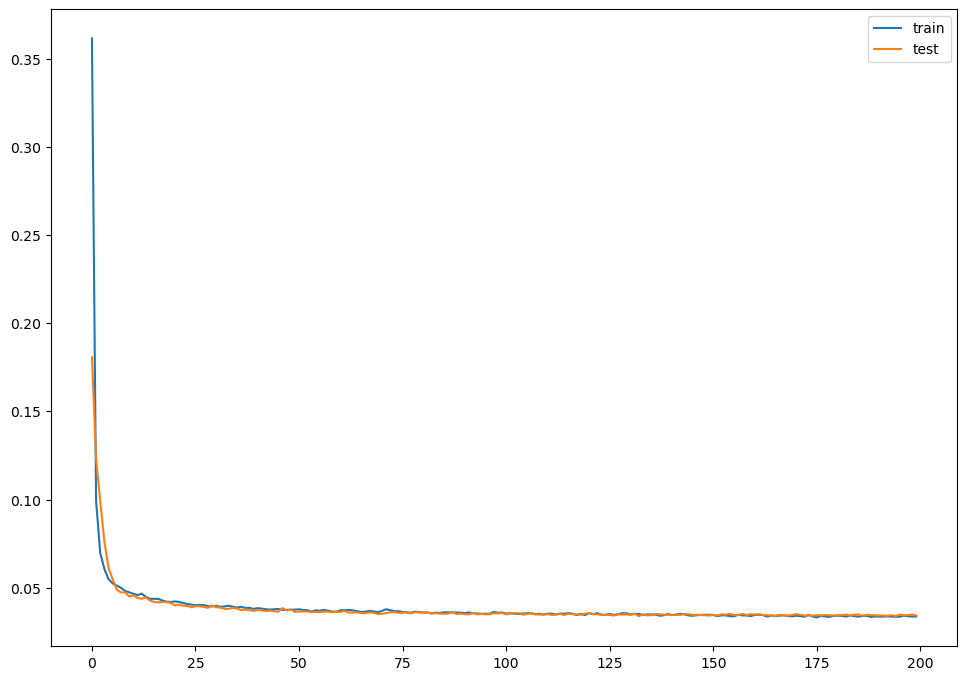

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
27/27 [==============================] - 0s 511us/step
Cross-Validated F1-Score - Logistic Regression: 0.6381827966908993
Cross-Validated F1-Score - Random Forest: 0.5796142050312028
Cross-Validated F1-Score - SVM: 0.6447073924302039
Cross-Validated F1-Score - XGBoost: 0.5842347036095832


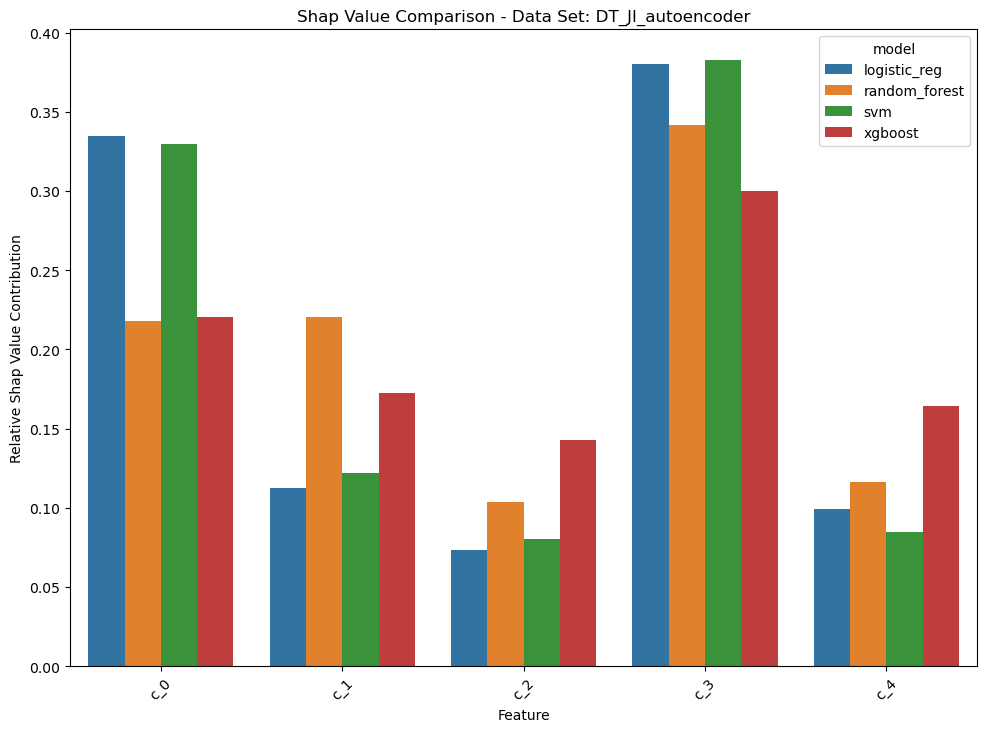

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
56/56 - 1s - loss: 0.6782 - val_loss: 0.2896 - 724ms/epoch - 13ms/step
Epoch 2/200
56/56 - 0s - loss: 0.1609 - val_loss: 0.1334 - 88ms/epoch - 2ms/step
Epoch 3/200
56/56 - 0s - loss: 0.0817 - val_loss: 0.0945 - 73ms/epoch - 1ms/step
Epoch 4/200
56/56 - 0s - loss: 0.0694 - val_loss: 0.0742 - 74ms/epoch - 1ms/step
Epoch 5/200
56/56 - 0s - loss: 0.0653 - val_loss: 0.0618 - 70ms/epoch - 1ms/step
Epoch 6/200
56/56 - 0s - loss: 0.0577 - val_loss: 0.0538 - 71ms/epoch - 1ms/step
Epoch 7/200
56/56 - 0s - loss: 0.0545 - val_loss: 0.0505 - 72ms/epoch - 1ms/step
Epoch 8/200
56/56 - 0s - loss: 0.0549 - val_loss: 0.0501 - 68ms/epoch - 1ms/step
Epoch 9/200
56/56 - 0s - loss: 0.0572 - val_loss: 0.0486 - 71ms/epoch - 1ms/step
Epoch 10/200
56/56 - 0s - loss: 0.0559 - val_loss: 0.0469 - 71ms/epoch - 1ms/step
Epoch 11/200
56/56 - 0s -

56/56 - 0s - loss: 0.0366 - val_loss: 0.0351 - 67ms/epoch - 1ms/step
Epoch 100/200
56/56 - 0s - loss: 0.0379 - val_loss: 0.0358 - 68ms/epoch - 1ms/step
Epoch 101/200
56/56 - 0s - loss: 0.0370 - val_loss: 0.0352 - 71ms/epoch - 1ms/step
Epoch 102/200
56/56 - 0s - loss: 0.0367 - val_loss: 0.0359 - 67ms/epoch - 1ms/step
Epoch 103/200
56/56 - 0s - loss: 0.0377 - val_loss: 0.0363 - 68ms/epoch - 1ms/step
Epoch 104/200
56/56 - 0s - loss: 0.0379 - val_loss: 0.0354 - 78ms/epoch - 1ms/step
Epoch 105/200
56/56 - 0s - loss: 0.0374 - val_loss: 0.0368 - 68ms/epoch - 1ms/step
Epoch 106/200
56/56 - 0s - loss: 0.0378 - val_loss: 0.0362 - 72ms/epoch - 1ms/step
Epoch 107/200
56/56 - 0s - loss: 0.0377 - val_loss: 0.0359 - 73ms/epoch - 1ms/step
Epoch 108/200
56/56 - 0s - loss: 0.0371 - val_loss: 0.0355 - 68ms/epoch - 1ms/step
Epoch 109/200
56/56 - 0s - loss: 0.0368 - val_loss: 0.0357 - 70ms/epoch - 1ms/step
Epoch 110/200
56/56 - 0s - loss: 0.0372 - val_loss: 0.0351 - 69ms/epoch - 1ms/step
Epoch 111/200
56/5

Epoch 198/200
56/56 - 0s - loss: 0.0347 - val_loss: 0.0353 - 73ms/epoch - 1ms/step
Epoch 199/200
56/56 - 0s - loss: 0.0345 - val_loss: 0.0353 - 69ms/epoch - 1ms/step
Epoch 200/200
56/56 - 0s - loss: 0.0345 - val_loss: 0.0355 - 69ms/epoch - 1ms/step


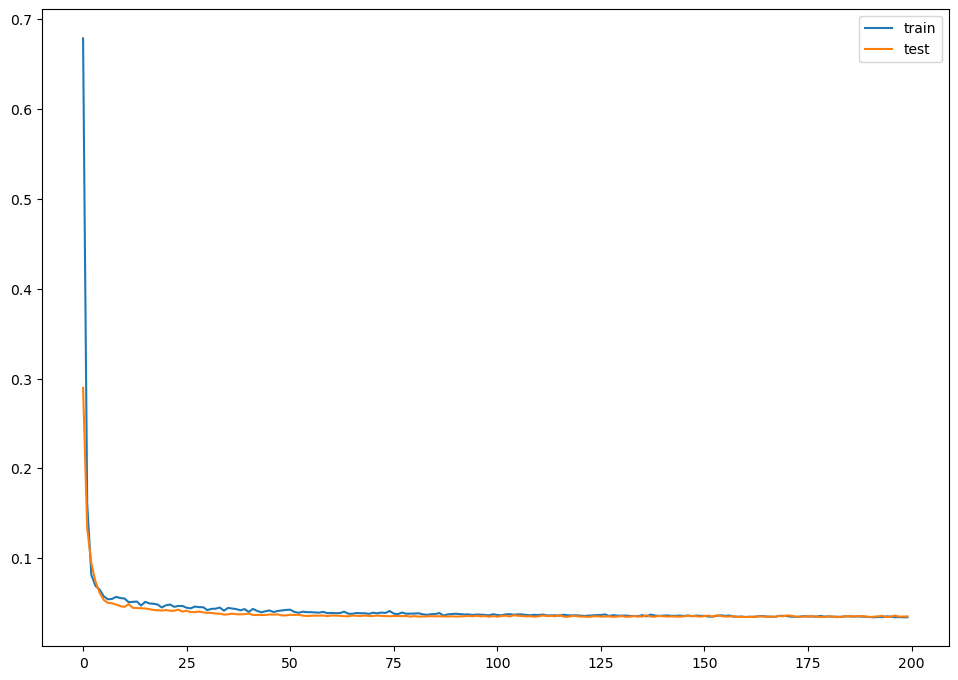

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
35/35 [==============================] - 0s 481us/step
Cross-Validated F1-Score - Logistic Regression: 0.9841100856134719
Cross-Validated F1-Score - Random Forest: 0.985866721857434
Cross-Validated F1-Score - SVM: 0.9843011870541435
Cross-Validated F1-Score - XGBoost: 0.9865024555225158


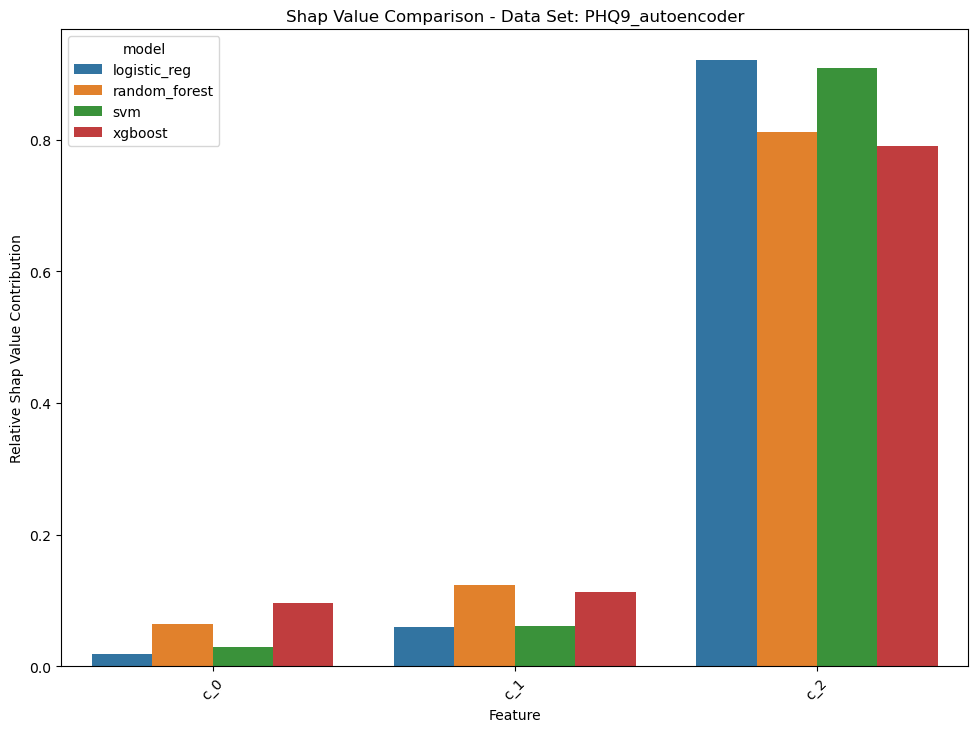

In [14]:
BF_CTU_df_autoencoder = perform_feature_extraction(BF_CTU_df, 0.2, epochs=200, df_name="BF_CTU_autoencoder")
BF_CTU_df_perf_df = compare_clfs(BF_CTU_df_autoencoder, df_name="BF_CTU_autoencoder", plot_name="autoencoder_shap_comparison_BF_CTUdf", path="plots/autoencoder", return_performance_df=True)

DT_CC_df_autoencoder = perform_feature_extraction(DT_CC_df, 0.2, epochs=200, df_name="DT_CC_autoencoder")
DT_CC_df_perf_df = compare_clfs(DT_CC_df_autoencoder, df_name="DT_CC_autoencoder", plot_name="autoencoder_shap_comparison_DT_CCdf", path="plots/autoencoder", return_performance_df=True)

DT_JI_df_autoencoder = perform_feature_extraction(DT_JI_df, 0.2, epochs=200, df_name="DT_JI_autoencoder")
DT_JI_df_perf_df = compare_clfs(DT_JI_df_autoencoder, df_name="DT_JI_autoencoder", plot_name="autoencoder_shap_comparison_DT_JIdf", path="plots/autoencoder", return_performance_df=True)

PHQ9_df_autoencoder = perform_feature_extraction(PHQ9_df, 0.2, epochs=200, df_name="PHQ9_autoencoder")
PHQ9_df_perf_df = compare_clfs(PHQ9_df_autoencoder, df_name="PHQ9_autoencoder", plot_name="autoencoder_shap_comparison_PHQ9df", path="plots/autoencoder", return_performance_df=True)

In [15]:
# Creating a dataframe to store the resultls and save them as a csv file
autoencoder_results_df = pd.concat([BF_CTU_df_perf_df, 
                                 DT_CC_df_perf_df, 
                                 DT_JI_df_perf_df, 
                                 PHQ9_df_perf_df])
autoencoder_results_df.to_csv("results/results_autoencoder.csv", index=False)

### Summary Table: Feature Selection with Autoencoder

In [16]:
results = pd.read_csv("results/results_autoencoder.csv")
results.pivot(index='Dataset', columns='Model', values='F1')

Model,lr,rf,svm,xgboost
Dataset,,,,
BF_CTU_autoencoder,0.83,0.83,0.83,0.79
DT_CC_autoencoder,0.72,0.74,0.73,0.67
DT_JI_autoencoder,0.64,0.58,0.64,0.58
PHQ9_autoencoder,0.98,0.99,0.98,0.99


### Relative Shap Value Comparison: Feature Selection with Autoencoder

Column 1 | Column 2
- | - 
![autoencoder_shap_comparison_BF_CTU](plots/autoencoder/autoencoder_shap_comparison_BF_CTUdf.png) | ![autoencoder_shap_comparison_DT_CC](plots/autoencoder/autoencoder_shap_comparison_DT_CCdf.png)
![autoencoder_shap_comparison_DT_JI](plots/autoencoder/autoencoder_shap_comparison_DT_JIdf.png) | ![autoencoder_shap_comparison_PHQ9](plots/autoencoder/autoencoder_shap_comparison_PHQ9df.png)

## Model Dependent vs Model Agnostic Methods

In this section we are going to add the Lasso penalty to the Logistic Regression, SVM and XGboost methods. Let's recall that the Lasso regularization can perform feature selection since it penalizes the L1 norm of the coefficients. Giving us a sparse solution.

We will do a grid search over different values of lambda and analyse if the same coefficients from the classifiers shrink similarly or not. This will help us understand if model agnostic features (methods?) perform better when trying to have predictors that share importance across classifiers.

In [287]:
# lambdas to explore
lambdas = np.linspace(0, 20, 20)
# logistics regression, svm uses c=1/lambda as penalty term
cs = 1/(lambdas + 0.00001)

The following code fits the estimators (LR, SVM and XGBoost) for every lambda in `np.linspace(0, 20, 20)` for the `BF_CTU` dataset. And appends the resuts to the list `all_dfs`. This list is later going to be use to create an animation to evaluate the evolution of the coeffiecients.

In [288]:
all_dfs = []
i = 0
for l, c in zip(lambdas, cs) :
    print(f"Lambda - l1 = {l}")
    df = compare_clfs(BF_CTU_df, 
                 df_name="BF_CTU", 
                 lr_penalty="l1", 
                 lr_C=c,
                 svm_penalty="l1",
                 svm_C=c, 
                 reg_alpha=l,
                 plot_comparison=False,
                 return_df=True
                )
    df["i"] = i
    all_dfs.append(df)
    i += 1
    
comparison = pd.concat(all_dfs, axis=0)

Lambda - l1 = 0.0
Cross-Validated F1-Score - Logistic Regression: 0.8098047607227533
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8110856959298172
Cross-Validated F1-Score - XGBoost: 0.8115609110462632
Lambda - l1 = 1.0526315789473684
Cross-Validated F1-Score - Logistic Regression: 0.8179686118479221
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.808459156942129
Cross-Validated F1-Score - XGBoost: 0.818346998101924
Lambda - l1 = 2.1052631578947367
Cross-Validated F1-Score - Logistic Regression: 0.8038842566642451
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8162247247076968
Cross-Validated F1-Score - XGBoost: 0.8359858553350417
Lambda - l1 = 3.1578947368421053
Cross-Validated F1-Score - Logistic Regression: 0.8046252537491416
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.81627162718962
Cross-

After fitting the estimators for 20 different lambda values we can create an animation and check if every coeffiecients evolves in the same way.

In [ ]:
from matplotlib import pyplot as plt
from celluloid import Camera
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
camera = Camera(fig)

labels = ['logistic_reg', 'svm', 'xgboost']
colors = ['#1f77b4', '#2ca02c', '#d62728']
handles = []
for c, l in zip(colors, labels):
    handles.append(Line2D([0], [0], color = c, label = l))

for i in range(len(lambdas)):
    data = comparison[comparison["i"] == i]
    sns.barplot(data=data, x="variable", y="value", hue="model", palette=colors)
    plt.legend(handles = handles, loc = 'upper left')
    ax.text(0, 1.01, f"Lambda (L1) = {lambdas[i]}", transform=ax.transAxes)
    ax.text(0.5, 1.01, f"iter = {i}/{len(lambdas)}", transform=ax.transAxes)
    camera.snap()
animation = camera.animate(interval = 500)
animation.save('plots/model_dependent/comparison_BF_CTU_df.mp4')

<video src="plots/model_dependent/comparison_BF_CTU_df.mp4" controls="controls" style="max-width: 730px;">
</video>

If we play the video above we can see how predictors start from a relatively nice position. Most of them share the same importance across models. But once we start increasing the lasso penalty (bigger lambda). We start noticing how each estimator shrinks different predictors.

For example, XGBoost (red) gives a lot of importance to predictors (`C1G`, `ES1G`). And Logistic Regression (blue) and SVM (green) share high importance for `C2G` whereas XGboost gives almost zero importance to it.

This experiment was run with the `BF_CTU` dataset and for time and computation constraints was not replicated with all the other 12 datasets. But we can almost surely expect a similar behaviour since each model has it's intrinsic methods to deal with this types of penalties.

If we would like to preserve the explainability and importance of features across models it would be advisable to use agnostic feature selection methods like the ones performed above (PCA, Sparse-PCA and Autoencoder) vs intrinsic feature selection methods.

## Conclusion

AIM: This project aims to examine and detremine the reliability, effectiveness and replicability of predictors in various classifiers in detecting malingering on psychological questionnaires. 

- about the f1 scores of the classifiers
- model agnostic vs model dependent
- how shap values affected the results
* Making a table of comparison of f1 score between model. 
* Autoencoder perform less good than pca and sparce-pca in term of stability in choosing the most importance paramaters.
* Plotting three plot of the same dataset showing the statement above.
* Pca: most stable model ; autocencoder less stable model.
* Future research: trying to pre-process the data before applying methods because of the imbalance in the dataset.
* If we would like to preserve the explainability and importance of features across models it would be advisable to use agnostic feature selection methods like the ones performed above (PCA, Sparse-PCA and Autoencoder) vs intrinsic feature selection methods. (took from the cell above, so if we add it to the conclusion we have to delete it from the cell above.)
